In [1]:
# .. ... .... .. ....

In [107]:
#import dependencies

import pandas as pd
import numpy as np
import warnings
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as bar
from sklearn.svm import SVR

from seaborn import kdeplot
from scipy.stats import weibull_min, gumbel_l, genextreme, dgamma, dweibull

from SALib.sample import saltelli
from SALib.analyze import sobol

from scipy.spatial.distance import cdist

from copulas.multivariate import GaussianMultivariate
from fitter import Fitter as f
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_percentage_error as mape
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from time import time
import torch
import torch.nn as nn
import torch.optim as optim
import os
import pickle
from seaborn import kdeplot 
warnings.filterwarnings('ignore')

In [44]:
#reading dataset 
# the dataset includes historical data, which will be used for obtaining the parameters of the distributions and sensitivity analysis.

df = pd.DataFrame()

df1 = pd.read_csv('//Users//matt//Desktop//ENCS6181//Project//metaheuristic opt//asos (3).csv',
                  low_memory=False,
                  parse_dates=['valid'])#1990 to 2000

df2 = pd.read_csv('//Users//matt//Desktop//ENCS6181//Project//metaheuristic opt//asos (4).csv',
                  low_memory=False,
                  parse_dates=['valid'])#2000 to 2010

df3 = pd.read_csv('//Users//matt//Desktop//ENCS6181//Project//metaheuristic opt//asos (5).csv',
                  low_memory=False,
                  parse_dates=['valid'])#2010 to 2020

df4 = pd.read_csv('//Users//matt//Desktop//ENCS6181//Project//metaheuristic opt//asos (6).csv',
                  low_memory=False,
                  parse_dates=['valid'])#2020 to present


In [45]:
#Concatenation of the dataframes!

df = pd.concat([df1, df2, df3, df4])


In [46]:
df

,station,valid,lon,lat,tmpc,relh,sped,p01m,metar
0,ELD,1990-01-01 00:00:00,-92.8133,33.2210,4.40,82.60,4.60,NaN,KELD 010000Z AUTO 22004KT 15SM 04/02 A3012 RMK...
1,HRO,1990-01-01 00:00:00,-93.1547,36.2615,3.90,52.65,14.95,NaN,KHRO 010000Z AUTO 28013KT 20SM SCT020 BKN025 0...
2,JBR,1990-01-01 00:00:00,-90.6464,35.8317,2.80,76.05,4.60,NaN,KJBR 010000Z AUTO 22004KT 20SM BKN246 03/M01 A...
3,FSM,1990-01-01 00:00:00,-94.3674,35.3366,3.90,54.68,13.80,NaN,KFSM 010000Z AUTO 29012KT 25SM SCT020 04/M04 A...
4,LRF,1990-01-01 00:00:00,-92.1465,34.9168,3.90,55.09,3.45,NaN,KLRF 010000Z AUTO 25003KT 7SM SCT015 04/M04 A3...
...,...,...,...,...,...,...,...,...,...
1710723,ARG,2023-06-18 23:56:00,-90.9251,36.1247,22.22,96.99,11.50,NaN,KARG 182356Z AUTO 05010KT 10SM CLR 22/22 A2970...
1710724,M19,2023-06-18 23:56:00,-91.1764,35.6377,25.00,76.62,10.35,0.0,KM19 182356Z AUTO 22009KT 10SM FEW046 OVC085 2...
1710725,VBT,2023-06-18 23:56:00,-94.2194,36.3457,25.00,64.21,6.90,0.0,KVBT 182356Z AUTO 29006KT 10SM SCT035 25/18 A2...
1710726,HKA,2023-06-18 23:58:00,-89.8300,35.9400,22.78,93.77,10.35,NaN,KHKA 182358Z AUTO 18009KT 3SM -TSRA BR FEW015 ...


In [47]:
#There was some duplicate data in the dataset (identical inputs and different outputs)

df.drop_duplicates(inplace=True)

In [48]:
# Exclusiong of data without metar data

df.dropna(subset = 'metar',
         inplace=True)
# Replacing NAN values in the dataset to facilitate the preprocessing
df.fillna(0,
         inplace = True)

In [49]:

# looking for freezing rain events!

df1 = df.loc[df.metar.str.contains('FZRA')]



df1.drop('metar',
        axis = 1,
        inplace = True)

In [50]:
# Extracting the records in which rainfall is recorded and windy condition

df1 = df1.loc[(df1.p01m>0)&(df1.sped > 0)&(df1.relh >= 80)&(df1.relh <= 100)]

In [51]:
# converting mph to m/sec.
df1.sped *= 0.44704



In [52]:
# Correction of mean wind speed
# Assumptions:
#             the terrain is open
#             the elevation of anemometer from the surface is 27 ft (8.2296 m)
alpha = 0.16

df1.sped = df1.sped*(10/8.2296)**alpha

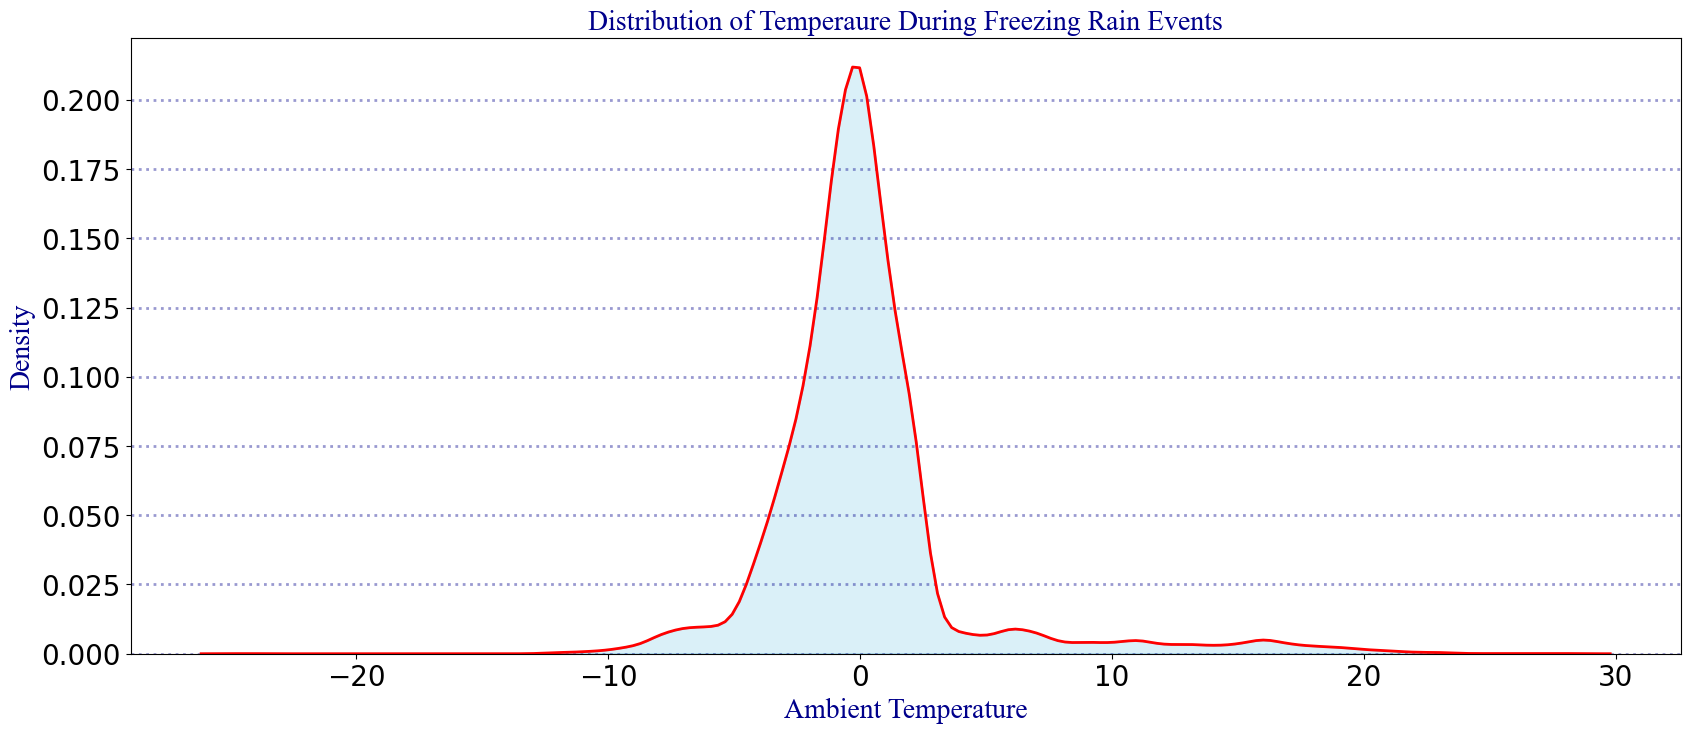

In [53]:
# Calculate the histogram
_, ax = plt.subplots(figsize=[20, 8])
n, bins, patches = plt.hist(df1.tmpc, density=True, histtype='step', lw=2, bins = 'auto')
plt.cla()
# Normalize the y-axis values
n_normalized = n / n.sum()

# Plot the normalized histogram

# plt.bar(bins[:-1], n_normalized, width=bins[1] - bins[0], align='edge', color='green' )

plt.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(df1.tmpc, fill=True, color='skyblue', alpha=0.3)
kdeplot(df1.tmpc, color='red', linewidth=2)

plt.title('Distribution of Temperaure During Freezing Rain Events', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.xlabel('Ambient Temperature', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show the plot
plt.show()

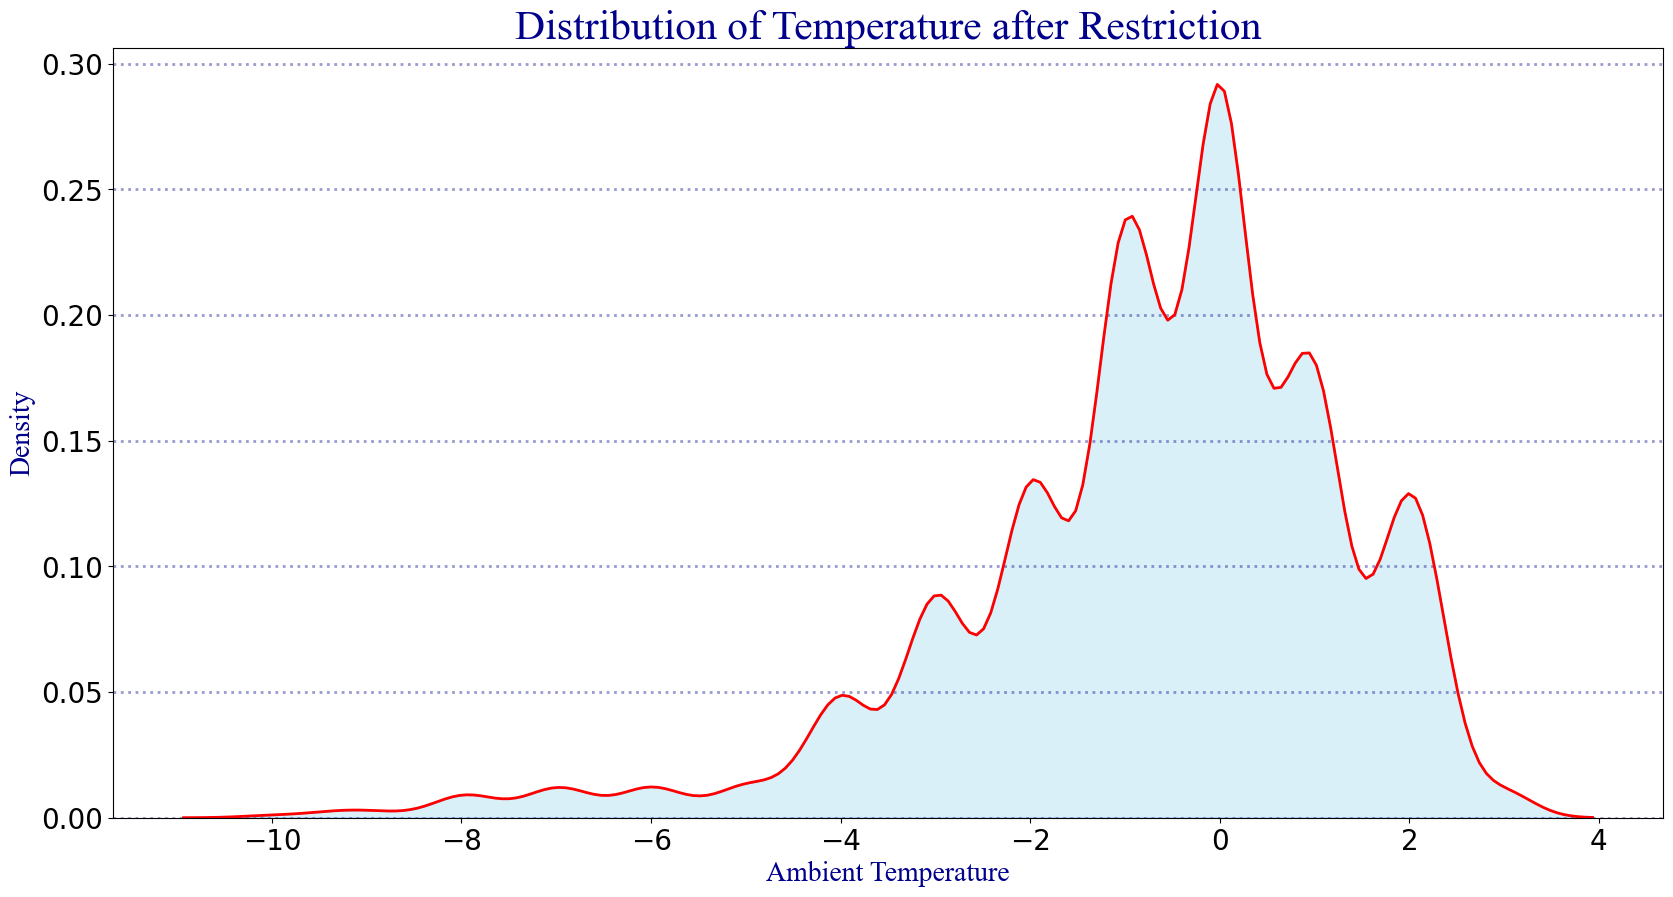

In [54]:
# applying the range ice
#Book Prof. Farzaneh, pp.33

df1 = df1.loc[(df1.tmpc >= -10)&(df1.tmpc <= 3.0)]


plt.subplots(1, figsize= [20, 10])
plt.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(df1.tmpc, fill=True, color='skyblue', alpha=0.3)
kdeplot(df1.tmpc, color='red', linewidth=2)
plt.title('Distribution of Temperature after Restriction', fontsize=30, fontname='times new roman', color='darkblue')
plt.xlabel('Ambient Temperature', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show the plot
plt.show()

In [55]:
df1

,station,valid,lon,lat,tmpc,relh,sped,p01m
97783,FSM,1990-12-27 05:00:00,-94.3674,35.3366,-1.00,100.00,7.955636,2.03
97794,FSM,1990-12-27 06:00:00,-94.3674,35.3366,-0.60,96.41,7.425260,3.05
97908,FSM,1990-12-27 15:00:00,-94.3674,35.3366,0.00,100.00,3.712630,0.51
98786,FSM,1990-12-30 01:00:00,-94.3674,35.3366,-2.10,100.00,7.425260,0.25
98817,FSM,1990-12-30 04:00:00,-94.3674,35.3366,-4.30,95.58,8.486011,0.25
...,...,...,...,...,...,...,...,...
1515769,PBF,2023-02-02 17:53:00,-91.9347,34.1750,0.00,92.22,5.834133,0.51
1515794,SGT,2023-02-02 17:56:00,-91.5750,34.5995,-0.61,92.18,3.712630,0.51
1515809,PBF,2023-02-02 18:32:00,-91.9347,34.1750,0.00,92.22,3.712630,0.76
1515831,PBF,2023-02-02 18:53:00,-91.9347,34.1750,0.00,92.22,3.182254,0.76


In [56]:
#For some situations we have several measurements during one hour.
# the latest one is employed as the representative of that period.

df = np.array([])
df2 = df1.groupby(['station', df1.valid.dt.year, df1.valid.dt.month, df1.valid.dt.day, df1.valid.dt.hour])#groupping based on the time of occurence.

for val in df2:
    val = val[1].sort_values('valid')
    
    if val.shape[0]>0:#if there is more than one measurement within one hour
        val = val.iloc[-1, :]

    df = np.append(df, val.values.reshape(1, -1))
    
df = pd.DataFrame(df.reshape(-1, 8), columns=['station', 'valid', 'lon', 'lat','tmpc','relh', 'sped', 'p01m'])

df

,station,valid,lon,lat,tmpc,relh,sped,p01m
0,ADF,2016-12-18 06:33:00,-93.0661,34.0998,0.0,80.22,3.71263,0.25
1,ADF,2018-01-12 05:56:00,-93.0661,34.0998,0.61,81.3,5.834133,0.25
2,ADF,2018-01-12 06:56:00,-93.0661,34.0998,-0.61,85.26,5.834133,0.25
3,ADF,2018-01-16 03:56:00,-93.0661,34.0998,0.61,91.51,5.834133,1.02
4,ADF,2018-01-16 04:56:00,-93.0661,34.0998,-0.61,92.18,4.773381,0.25
...,...,...,...,...,...,...,...,...
5375,XNA,2021-02-10 14:53:00,-94.307,36.282,-2.78,88.65,4.243006,0.25
5376,XNA,2022-02-03 06:53:00,-94.307,36.282,-8.28,87.38,8.486011,1.52
5377,XNA,2022-02-03 07:53:00,-94.307,36.282,-8.89,87.32,7.42526,0.25
5378,XNA,2022-02-23 23:53:00,-94.307,36.282,-7.78,91.72,5.834133,0.25


In [57]:
#herein, as there is no specific criterion to distringuish the accumulation process, we are intended to model
#the total ice accretion during one hour.

In [62]:
try:
    df.drop(labels=['station', 'valid'],
           axis =1, inplace = True)
except:
    pass

df= df.astype(float)

df

,lon,lat,tmpc,relh,sped,p01m
0,-93.0661,34.0998,0.00,80.22,3.712630,0.25
1,-93.0661,34.0998,0.61,81.30,5.834133,0.25
2,-93.0661,34.0998,-0.61,85.26,5.834133,0.25
3,-93.0661,34.0998,0.61,91.51,5.834133,1.02
4,-93.0661,34.0998,-0.61,92.18,4.773381,0.25
...,...,...,...,...,...,...
5375,-94.3070,36.2820,-2.78,88.65,4.243006,0.25
5376,-94.3070,36.2820,-8.28,87.38,8.486011,1.52
5377,-94.3070,36.2820,-8.89,87.32,7.425260,0.25
5378,-94.3070,36.2820,-7.78,91.72,5.834133,0.25


In [63]:
df1 = df.copy()

In [64]:
df1.drop_duplicates(subset = ['tmpc', 'relh', 'sped', 'p01m'], inplace = True)

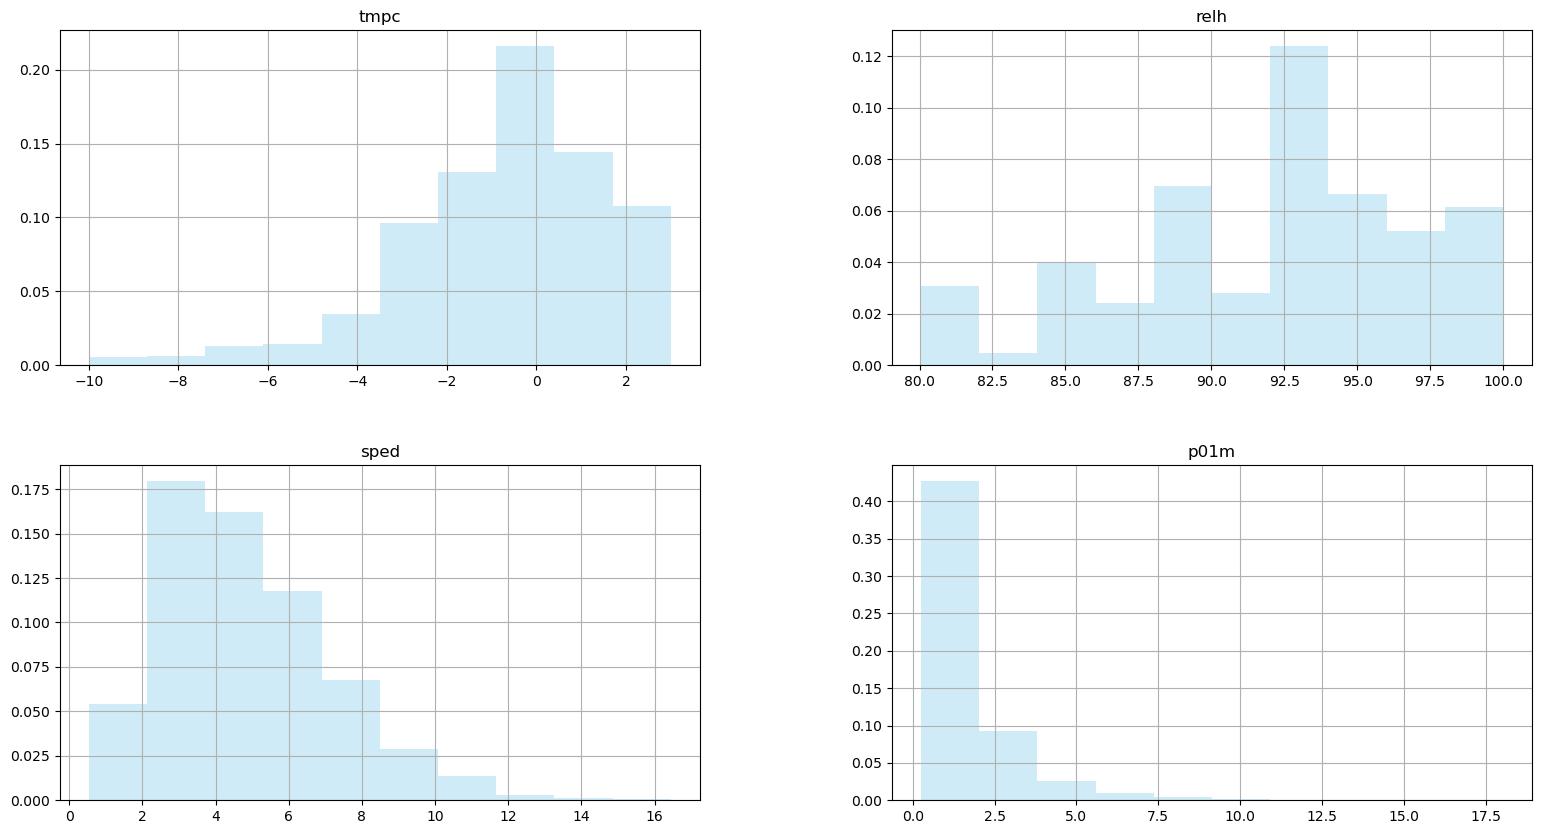

In [65]:
df1.iloc[:, 2:].hist(density = True, figsize= [19, 10], color = 'skyblue', alpha = 0.4)
_ = plt.show()

In [63]:
#herein, we aim to find the statistical characteristics of each parameters for performing the global sensitivity analysis

# wind speed

Fitting 9 distributions: 100%|████████████████████| 9/9 [00:00<00:00, 30.31it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
weibull_min,2.035452,inf,-32755.756746,inf,0.064987,3.573661e-16
gamma,2.044981,798.534926,-32735.746945,inf,0.073434,1.552276e-20
lognorm,2.051007,766.816427,-32723.143166,inf,0.075905,6.506217e-22
genextreme,2.058534,771.584870,-32707.450287,inf,0.081443,3.636387e-25
gumbel_l,2.219933,1621.340548,-32392.442997,inf,0.193545,4.773437e-141


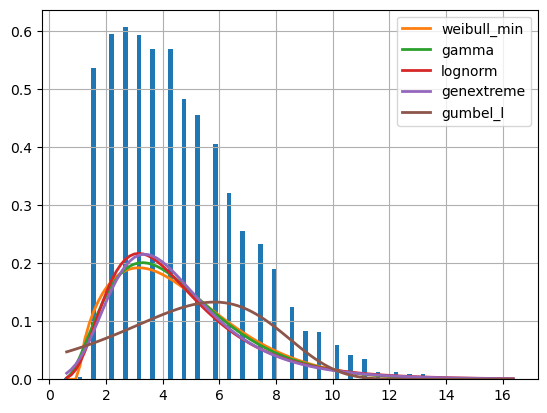

In [21]:
model = f(df1.sped, distributions = ['normal', 'lognorm', 'expon', 'weibull_min', 'gumbel_l', 'gamma', 'genextreme', 'genpareto', 'weibull_min'])

model.fit()
model.summary()       

In [66]:
#fitting wind speed with Weibull distribution

weibull_min.fit(df1.sped)

(1.5826131091488467, 1.0543512882910764, 3.9500162866862043)

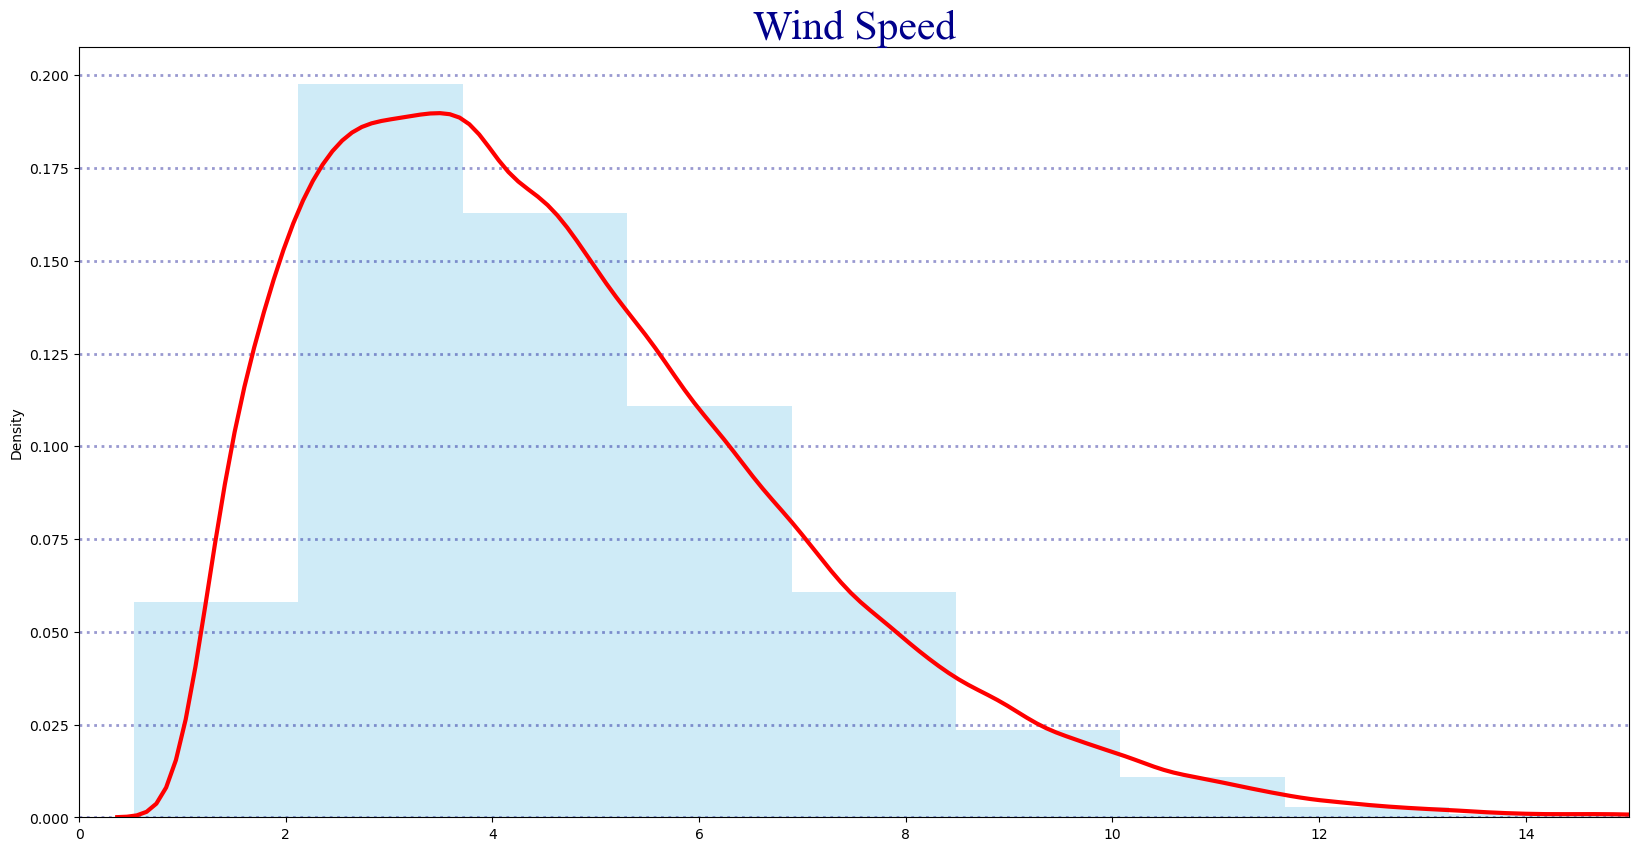

In [69]:
np.random.seed(123)
wind_samples = weibull_min.rvs(1.5826131091488467, 1.0543512882910764, 3.9500162866862043, size= 100_000)

ax, _ = plt.subplots(figsize = [20, 10])
plt.hist(df.sped, density = True, color = 'skyblue', alpha = 0.4)
kdeplot(wind_samples, color= 'r', lw =3)
plt.xlim(0, 15)
plt.title('Wind Speed', fontname = 'times new roman', fontsize=30, color='darkblue')
plt.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')

plt.show()

# Precipitation

Fitting 7 distributions: 100%|████████████████████| 7/7 [00:00<00:00, 14.69it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
weibull_min,0.398068,965.774341,-39746.600117,inf,0.239963,1.404000e-217
expon,0.772695,1545.438162,-36913.554990,inf,0.239963,1.403999e-217
genextreme,1.530589,979.091438,-33976.977234,inf,0.366307,0.000000e+00
lognorm,2.010241,996.541406,-32809.149011,inf,0.441775,0.000000e+00
gumbel_l,2.763934,6217.671939,-31453.485464,inf,0.388204,0.000000e+00


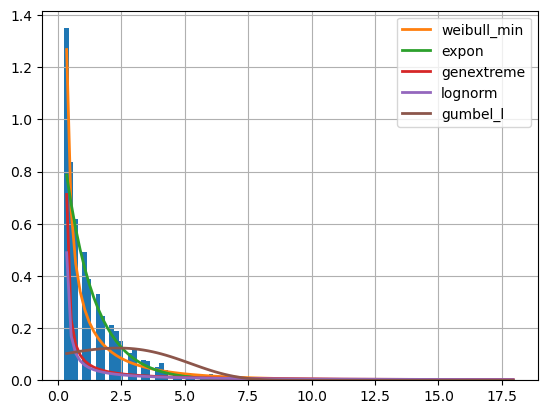

In [24]:
np.random.seed(123)


model = f(df1.p01m, distributions = ['normal', 'lognorm', 'expon', 'weibull_min', 'gumbel_l', 'genextreme', 'weibull_min'])
model.fit()
model.summary()

In [25]:
weibull_min.fit(df1.p01m)

(0.59462333166121, 0.24999999999999997, 0.9707987118314221)

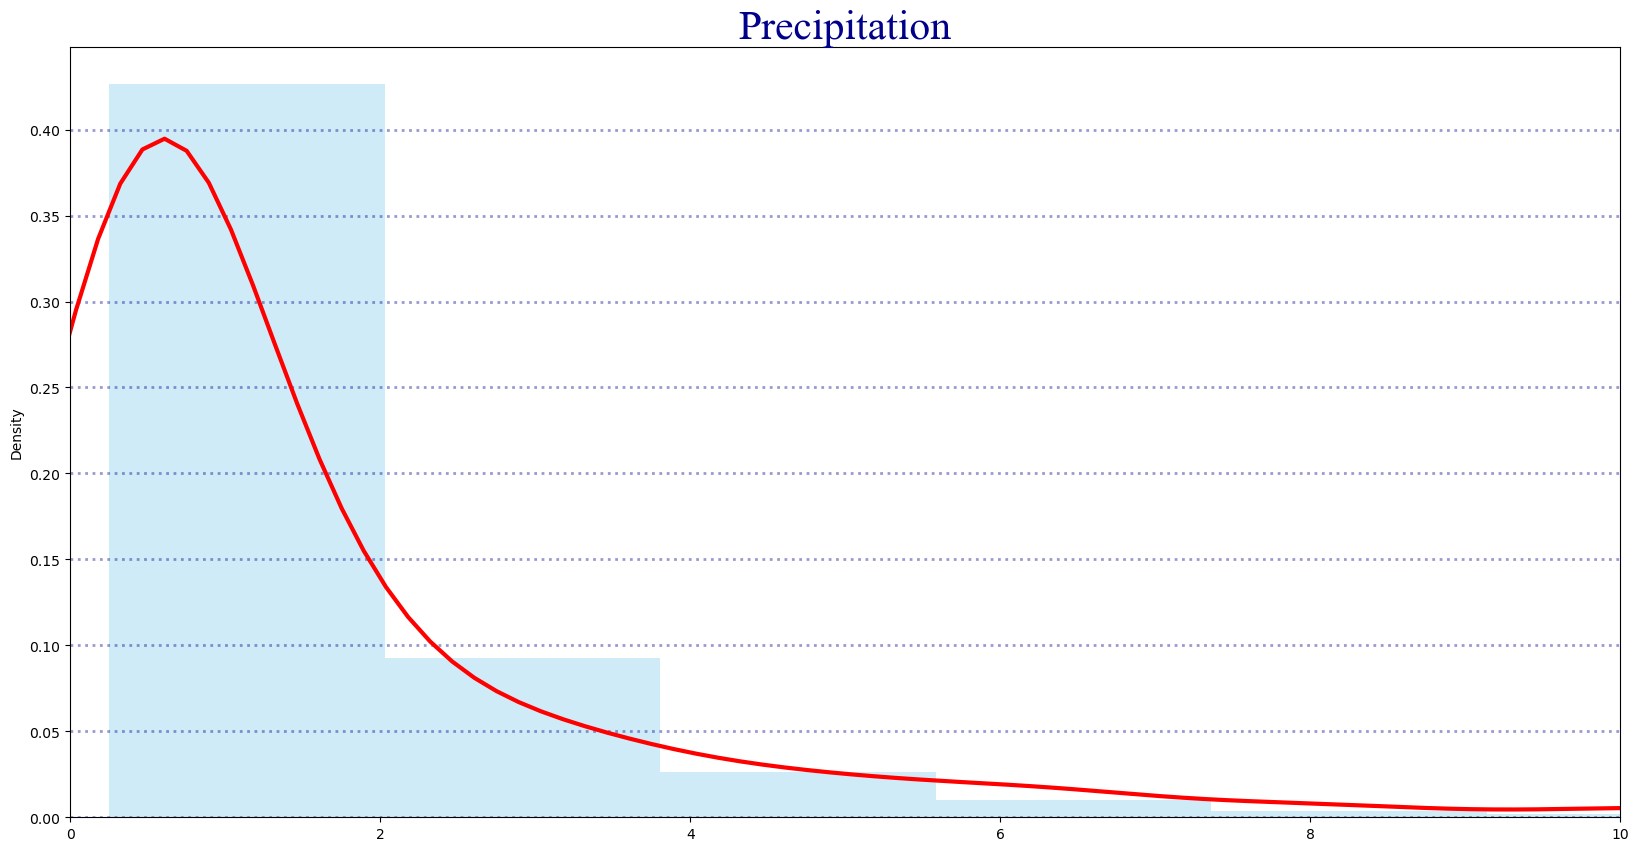

In [68]:
np.random.seed(123)
p01m_samples = weibull_min.rvs(0.59462333166121, 0.24999999999999997, 0.9707987118314221, size= 1_000)

ax, _ = plt.subplots(figsize = [20, 10])
plt.hist(df1.p01m, density = True, color = 'skyblue', alpha = 0.4, bins = 10)
kdeplot(p01m_samples, color= 'r', lw =3)
plt.xlim(0, 10)
plt.title('Precipitation', fontname = 'times new roman', fontsize=30, color='darkblue')
plt.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
plt.show()

# Temperature

Fitting 9 distributions: 100%|████████████████████| 9/9 [00:00<00:00, 21.60it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gumbel_l,3.260622,688.709161,-30745.498339,inf,0.096907,1.808690e-35
weibull_min,3.260635,690.866629,-30737.118161,inf,0.097000,1.549646e-35
weibull_max,3.276388,698.667674,-30716.471654,inf,0.095518,1.803354e-34
genextreme,3.276390,698.652621,-30716.468482,inf,0.095501,1.856301e-34
lognorm,3.314509,813.181588,-30666.914257,inf,0.128296,6.207310e-62


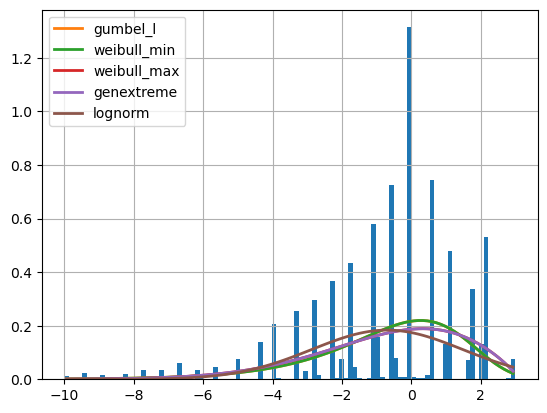

In [27]:
model_T = f(df1.tmpc, distributions = ['normal', 'lognorm', 'expon', 'weibull_min', 'weibull_max', 'gumbel_l', 'gamma', 'genextreme', 'genpareto'])
model_T.fit()
model_T.summary()

In [28]:
gumbel_l.fit(df1.tmpc)

(0.27354027504565886, 1.675816261238136)

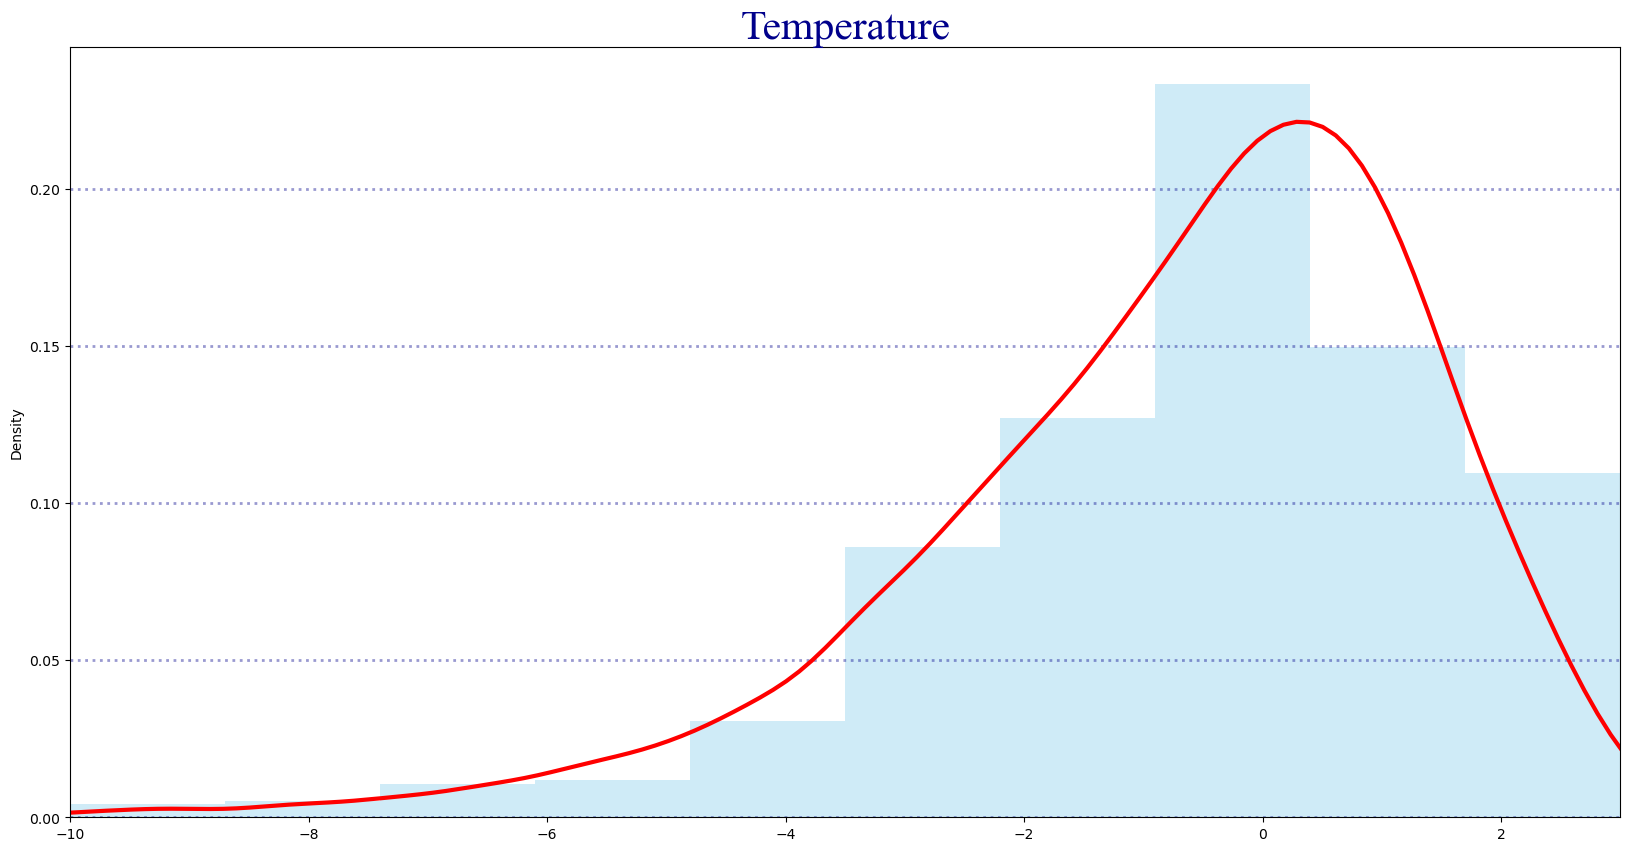

In [70]:

np.random.seed(123)
tmpc_samples = gumbel_l.rvs(0.27354027504565886, 1.675816261238136, size= 10_000)

ax, _ = plt.subplots(figsize = [20, 10])
plt.hist(df.tmpc, density = True, color = 'skyblue', alpha = 0.4)
kdeplot(tmpc_samples, color= 'r', lw =3)
plt.xlim(-10, 3)
plt.title('Temperature', fontname = 'times new roman', fontsize=30, color='darkblue')
plt.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')

plt.show()

# Relative humidity

Fitting 11 distributions: 100%|█████████████████| 11/11 [00:00<00:00, 22.44it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
dweibull,1.128890,706.179891,-35281.100826,inf,0.153725,7.240972e-89
genpareto,1.213911,797.956116,-34970.030132,inf,0.466547,0.000000e+00
dgamma,1.219608,697.490311,-34949.972610,inf,0.160854,2.629516e-97
weibull_min,1.276531,652.825643,-34754.549819,inf,0.100231,6.418331e-38
genextreme,1.276755,647.951349,-34753.798746,inf,0.107158,2.720070e-43


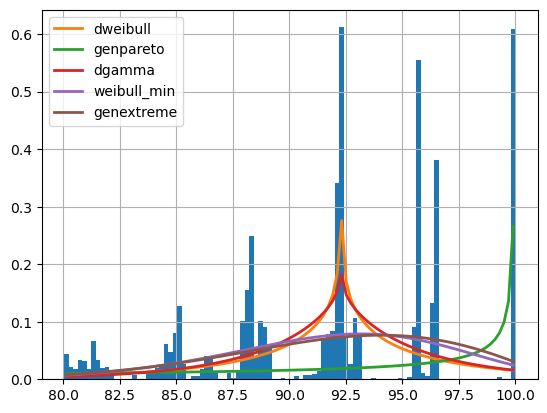

In [30]:
model_T = f(df1.relh,distributions = ['normal', 'lognorm', 'expon', 'weibull_min', 'weibull_max', 'gumbel_l', 'gamma', 'genextreme', 'genpareto', 'dweibull', 'dgamma'])

model_T.fit()
model_T.summary()

In [31]:
dweibull.fit(df1.relh)

(0.8054217377035391, 92.29000000000002, 3.659766790811789)

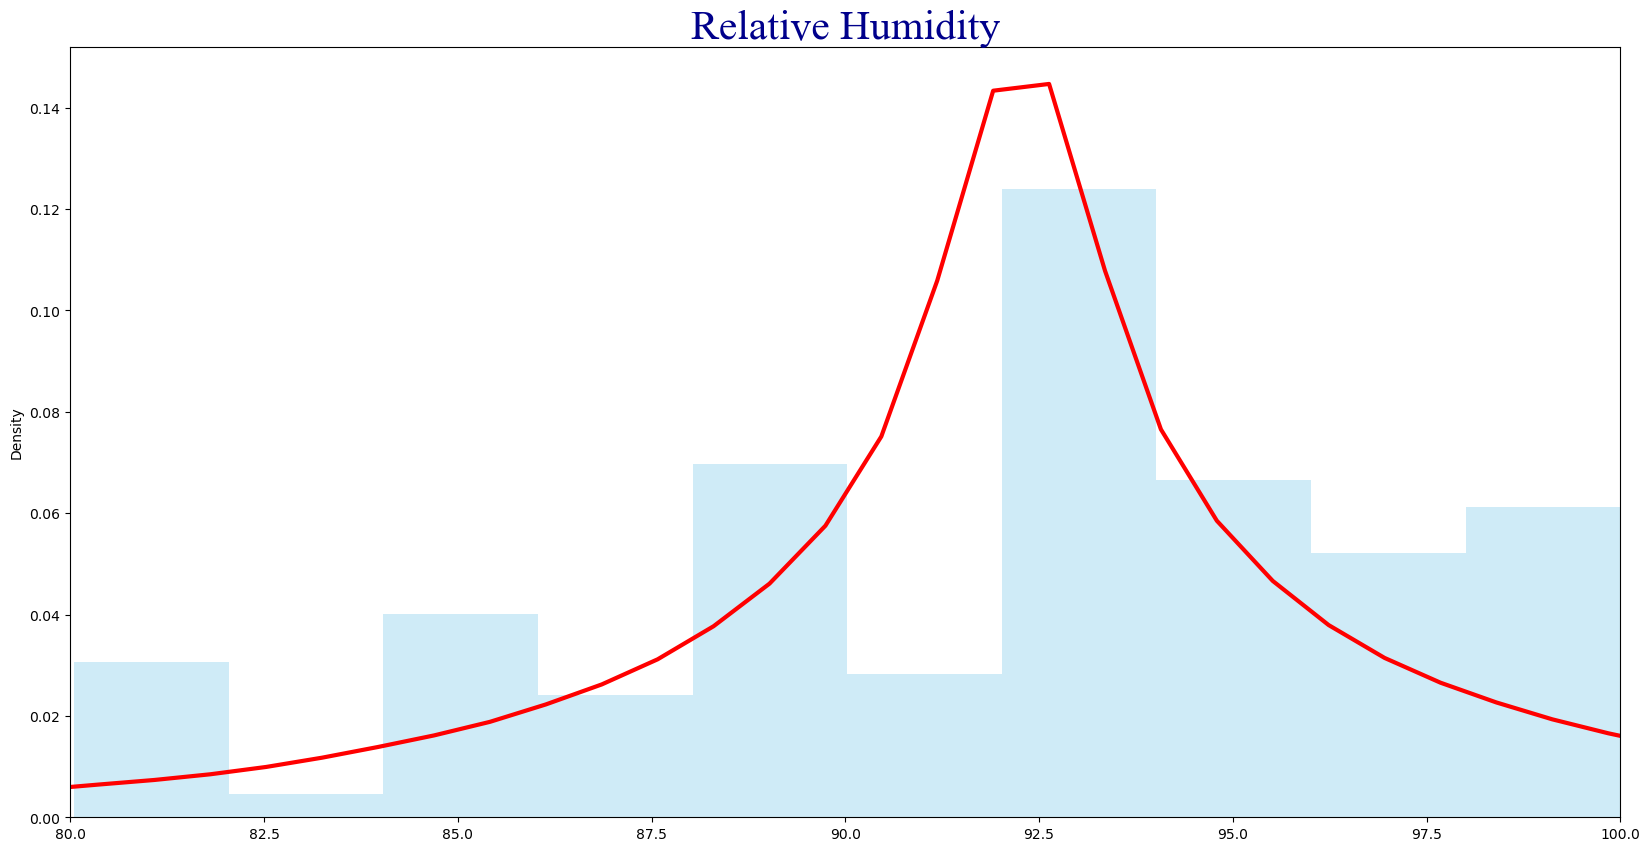

In [32]:

np.random.seed(123)
tmpc_samples = dweibull.rvs(0.8054217377035391, 92.29000000000002, 3.659766790811789, size= 100_000)

ax, _ = plt.subplots(figsize = [20, 10])
plt.hist(df1.relh, density = True, color = 'skyblue', alpha = 0.4)
kdeplot(tmpc_samples, color= 'r', lw =3)
plt.xlim(80, 100)
plt.title('Relative Humidity', fontname = 'times new roman', fontsize=30, color='darkblue')
plt.show()

In [71]:
wind_dist = weibull_min(1.5826131091488467, 1.0543512882910764, 3.9500162866862043)
p01m_dist = weibull_min(0.59462333166121, 0.24999999999999997, 0.9707987118314221)
tmpc_dist = gumbel_l(0.27354027504565886, 1.675816261238136)
relh_dist = dweibull(0.8054217377035391, 92.29000000000002, 3.659766790811789)

In [72]:
# Herein, the CDF of ASOS data should be computed using the fitted distributions.
u1 = wind_dist.cdf(df1.sped)
u2 = p01m_dist.cdf(df1.p01m)
u3 = tmpc_dist.cdf(df1.tmpc)
u4 = relh_dist.cdf(df1.relh)

u = np.stack([u1, u2, u3, u4])

In [73]:
u = pd.DataFrame(u.T, columns= ['sped', 'p01m', 'tmpc', 'relh'])
u

,sped,p01m,tmpc,relh
0,0.413926,1.454397e-10,0.572327,0.036597
1,0.741341,1.454397e-10,0.705462,0.044261
2,0.741341,1.454397e-10,0.445805,0.092098
3,0.741341,5.815846e-01,0.705462,0.374910
4,0.597090,1.454397e-10,0.445805,0.471145
...,...,...,...,...
4279,0.118415,1.454397e-10,0.807430,0.044815
4280,0.741341,4.943820e-01,0.705462,0.374910
4281,0.934058,6.906291e-01,0.006053,0.140830
4282,0.881265,1.454397e-10,0.004210,0.139087


In [74]:
#fitting data with Gaussian Copula

copula = GaussianMultivariate()
copula.fit(u.to_numpy())



In [75]:
np.random.seed()

samples = copula.sample(20_000) #sampling from the fitted copula

samples.columns = ['sped', 'p01m', 'tmpc', 'relh']
samples.iloc[:, 0] = wind_dist.ppf(samples.iloc[:, 0])
samples.iloc[:, 1] = p01m_dist.ppf(samples.iloc[:, 1])
samples.iloc[:, 2] = tmpc_dist.ppf(samples.iloc[:, 2])
samples.iloc[:, 3] = relh_dist.ppf(samples.iloc[:, 3])

samples.dropna(inplace = True)



In [76]:
samples = samples.loc[(samples.relh >= 80) & (samples.relh <= 100)] # restricting dataset to only 80-100 saturation(assumed).
samples = samples.loc[(samples.tmpc <= 3.0)&(samples.tmpc>= -10)] # Range for ambient temperature
samples = samples.loc[(samples.sped >0)&(samples.p01m > 0)&(samples.p01m <= 20)]
samples.describe()

,sped,p01m,tmpc,relh
count,13907.000000,13907.000000,13907.000000,13907.000000
mean,4.562425,1.576477,-0.594615,91.944535
std,2.157299,1.718451,1.877072,4.265612
min,1.059243,0.250000,-9.964754,80.009162
25%,2.856878,0.534220,-1.608814,88.965970
50%,4.238110,1.024978,-0.285769,92.272069
75%,5.915556,1.984264,0.681599,95.309841
max,16.357074,19.927966,2.999247,99.995869


In [77]:
def dens_ice(temp):
    """
    
    :param temp: Ambient temperature °C
    :return: density of accreted ice in gr/cm3
    """
    
    # This model is based on the Macklin model (1962)
    
    # for calculating the ice density, some assumptions have been made:
    #1. The droplet impact velocity is assumed to be 10m/sec.
    #2. The droplet size is assumed to be 25 micrometers.
    #3. It is assumed that the cable's surface temperature is equal to the ambient temperature (It's assumed to be not constant)!
    
    u0 = 10 # droplet impact velocity
    d = 25 # size of droplet in μm
    
    if (temp >= 0)&(temp <= 3): # wet snow
        return 0.8# A constant density of 800 kg/m3 is assumed for wet snow.
    
    elif (temp>= -10)&(temp<0): #rime and glaze
        R = -u0*d/(2*temp)
        
        if R<=10:
            return 0.1**R**0.76
        
        elif R<= 60:
            return R*(R + 5.61)**(-1)
        
        elif R>60:
            return 0.92
        
        else:
            raise ValueError('Issue in calculating the density of ice!')
            
    else: # Out of bound temperature!
        print(temp)
        raise ValueError('Out of bound temperature')
    

In [78]:
def accre_efficiency(alpha1, alpha2, w, v, T):
    """
    This function is an implementation of the Makkonen, 2000 model.
    
    :param alpha1:  The collision efficiency  
    :param alpha2:  The sticking efficiency
    :param w:       Liquid water fraction
    :param u:       Wind speed
    :param T:       Ambient temperature
    :return:        The collision efficiency
    """
    
    F = alpha1*alpha2*\
        w*v         # the flux density of water to the surface
    
    Lambda = 0.3    # The flux density of water to the surface
    Lf = 80         # cal/gr
    h =  1_000      # The convective heat-transfer coefficient
    Le = 2.25e-6    # The latent heat of vaporization
    r = 0.79        # The recovery factor for viscous heating
    ts = 0          # Temperature of the icing surface
    Cp =1.005e3     # The specific heat of air
    P = 101325      # The air pressure
    Cw = 4184       # The specific heat of water
    eps = 0.622     # The ratio of the molecular weights of dry air and water vapour
    es = np.exp(
    20.386 - 5132/\
    (273.15 + 0))   # The saturation water vapour pressure over the accretion surface / https://en.wikipedia.org/wiki/Vapour_pressure_of_water#:~:text=The%20saturation%20vapour%20pressure%20is,it%20would%20evaporate%20or%20sublimate.
    ea = np.exp(
    20.386 - 5132/\
    (273.15 + T))   # The ambient vapour pressure in the airstream
    a =  8.1e7      # The radiation linearization constant
    ta = T          # The air temperature
    
    
    alpha3 = 1/(F*(1- Lambda)*Lf)*((h + 6*a)*(ts - T) + h*eps*Le/(Cp*P)*(es - ea)-
                                  h*r*v**2/(2*Cp)+ F*Cw*(ts - ta))
    if T <= -3:
        return 1.0 # rime ice
    elif (T<-10)|(T>3):
        print(T)
        raise ValueError('Out of bound temperature!')
    try:
        if (alpha3 >0)&(alpha3 < 1):#wet growth
            if np.array(alpha3).shape[0]>1:
                alpha3 = alpha3[0]
            return alpha3

        else: # dry growth
            return 1.0 
    except:
        print(alpha3)
        raise ValueError('Error in computing α3')

In [79]:
def check_for_ice_values(ice_val):
    if (ice_val> 0)&(ice_val <= 1): #maximum ice accretion cannot exceed 1m !!!!!!
        return ice_val
    else:
        return np.NaN

In [80]:
def check_alpha(alpha):
    
    if (alpha>0)&(alpha <= 1):
        return alpha
    
    else:
        return 1

In [81]:
def check_mass(mass):
    if mass > 0:
        return mass
    elif mass <= 0:
        return 0
    else:
        raise ValueError('Incorrect mass value!')

In [82]:
# Total accreted ice within one hour using Makkonen model

samples['r01m'] = 0


A_conduct = 435e-6 #conductor ACSR435
D_conduct = (4/np.pi*A_conduct)**0.5 #Diameter of the conductor

ro_air = 101325/(287.058*(273.15 + samples.tmpc.to_numpy())) #P_atmosphere/(r_sepcific*T)
ro_w   = 1000 #density of water
d = 25e-6     # Median volume diameter of droplets

mu = 1.8e-5 # variation of absolute viscosity at different temperatures is neglected.

M_sublim = -0.02 #kg/m.h sublimation rate at dry hours
M_meltin = -0.3 #kg/m.h  typical melting rate at dry hours

# in the following lines of code, the ambient temperature is used an the index for distinguishing 
# different types of ice. In addition, the effect of refreezing for wet snow is disregarded.

for row in range(samples.shape[0]):

    ro_ice = dens_ice(samples.iloc[row, 2])#calculating density of ice
    ro_ice *= 1000 #unit conversion
    
    K = ro_w*d**2/(9*mu*D_conduct) # intertia parameter
    Re = ro_air[row]*d*samples.iloc[row, 0]/mu # Reynolds number
    phi = Re**2/K # Langmuir parameter
    
    if samples.iloc[row, 2] <= -3: #rime
        

        lwc = 0.067*samples.iloc[row, 1]**0.848     # Best model, 1949 
        
        # α1
        A = 1.066*K**(-0.00616)*np.exp(-1.103*K**(-0.688))
        B = 3.641*K**(-0.498)*np.exp(-1.497*K**(-0.694))
        C = 0.00637*(phi - 100)**0.381
        
        alpha1 = A - 0.028- C*(B - 0.0454)
        alpha1 = check_alpha(alpha1)#check for the valid range of alpha
        # α2
        alpha2 = 1.0# No bounce off
        alpha2 = check_alpha(alpha2)#check for the valid range of alpha
        # α3
        alpha3 = 1.0# No dripping
        alpha3 = check_alpha(alpha3)#check for the valid range of alpha
        I = alpha1*alpha2*alpha3*lwc*samples.iloc[row, 0]*A_conduct #Mass per unit length
        
        M = I*3600 # total mass during one hour period
        
        M += M_sublim   # Reducing the sublimation
        
        samples.iloc[row, -1] = 0.5*(np.sqrt(4/np.pi*M/ro_ice + D_conduct**2) - D_conduct) # calculating the ERE
        
        samples.iloc[row, -1] = check_for_ice_values(samples.iloc[row, -1]) #check for valid range of ice accretion
        
    elif samples.iloc[row, 2] <= 0.0: #glaze
        
        lwc = 0.067*samples.iloc[row, 1]**0.848  # Best model, 1949
        
        
        # α1
        A = 1.066*K**(-0.00616)*np.exp(-1.103*K**(-0.688))
        B = 3.641*K**(-0.498)*np.exp(-1.497*K**(-0.694))
        C = 0.00637*(phi - 100)**0.381
        
        alpha1 = A - 0.028- C*(B - 0.0454)
        alpha1 = check_alpha(alpha1)#check for the valid range of alpha
        
        # α2
        alpha2 = 1.0# No bounce off
        alpha2 = check_alpha(alpha2)#check for the valid range of alpha
        # α3
        alpha3 = accre_efficiency(alpha1, alpha2, lwc, samples.iloc[row, 0], samples.iloc[row, 2])
        
        alpha3 = check_alpha(alpha3)#check for the valid range of alpha
        
        I = alpha1*alpha2*alpha3*lwc*samples.iloc[row, 2]*A_conduct #Mass per unit length
        
        M = I*3600 # total mass during one hour period
        
        M += M_sublim  # Reducing the term of sublimation
        
        samples.iloc[row, -1] = 0.5*(np.sqrt(4/np.pi*M/ro_ice + D_conduct**2) - D_conduct)  # Calculationg of ERE
        samples.iloc[row, -1] = check_for_ice_values(samples.iloc[row, -1]) #check for valid range of ice accretion
    else: #wet snow
        
        # α1
        A = 1.066*K**(-0.00616)*np.exp(-1.103*K**(-0.688))
        B = 3.641*K**(-0.498)*np.exp(-1.497*K**(-0.694))
        C = 0.00637*(phi - 100)**0.381
        
        alpha1 = A - 0.028- C*(B - 0.0454)
        alpha1 = check_alpha(alpha1)#check for the valid range of alpha
        # α2
        if samples.iloc[row, 2] == 0:
            alpha2 = 1.0
        else:
            alpha2 = 1/(samples.iloc[row, 2])**0.5
            
        alpha2 = check_alpha(alpha2)#check for the valid range of alpha
        # α3
        
        vs = 1.7 # The terminal fall speed of wet snowflakes
    
        LWC_wt = samples.iloc[row, 1]/vs    # Nyggard et. al        
        
        if samples.iloc[row, 0] <1: # For lower wind speed, there is no dripping.
            
            alpha3 = 1.0
        else:
            alpha3 = accre_efficiency(alpha1, alpha2,LWC_wt, samples.iloc[row, 0], samples.iloc[row, 2])
            
        alpha3 = check_alpha(alpha3)#check for the valid range of alpha
    

        
        I = alpha1*alpha2*alpha3*LWC_wt*samples.iloc[row, 0]*A_conduct #Mass per unit length
        
        M = I*3600 # total mass during one hour period
        
        M += M_meltin # Reducing the term of melting
        
        samples.iloc[row, -1] = 0.5*(np.sqrt(4/np.pi*M/ro_ice + D_conduct**2) - D_conduct) # Calculation of ERE
        
        samples.iloc[row, -1] = check_for_ice_values(samples.iloc[row, -1]) #check for valid range of ice accretion
        
print(f'{samples.r01m.isna().sum():.0f} NaN was removed!')

samples.dropna(inplace = True)

samples = samples.loc[samples.r01m >0] #excluding records without ice accretion

samples.iloc[:, -1] *= 1000 #unit conversion

6652 NaN was removed!


In [83]:
samples

,sped,p01m,tmpc,relh,r01m
0,5.002609,3.024682,1.825965,85.653264,52.446144
10,8.192106,0.250156,1.421819,87.082855,13.708794
11,2.270238,0.539206,0.230317,95.992015,9.860905
14,7.241057,0.254985,0.176514,95.592634,14.611593
15,5.296925,0.923370,1.911987,94.220133,24.503573
...,...,...,...,...,...
19986,2.482503,0.253477,0.822011,86.500795,4.035957
19988,2.717070,1.351188,-3.542363,95.865413,4.568035
19989,7.417609,5.876368,0.713679,86.924528,114.705761
19994,1.927292,2.189107,1.678914,83.043660,23.054523


In [84]:
def remove_outliers(df, columns= None, lower_quantile=0.25, upper_quantile=0.75, threshold=1.5):
    filtered_df = df.copy()
    
    columns = []
    if columns == None:
        columns = filtered_df.columns
    
    for column in columns:
        # Calculate the lower and upper quartiles
        q1 = np.quantile(filtered_df[column], lower_quantile)
        q3 = np.quantile(filtered_df[column], upper_quantile)
        
        # Calculate the interquartile range (IQR)
        iqr = q3 - q1
        
        # Calculate the lower and upper bounds
        lower_bound = q1 - (threshold * iqr)
        upper_bound = q3 + (threshold * iqr)
        
        # Filter the data within the specified bounds
        filtered_df = filtered_df[(filtered_df[column] >= lower_bound) & (filtered_df[column] <= upper_bound)]
    
    return filtered_df

samples = remove_outliers(samples, None)

In [85]:
samples = samples.loc[samples.r01m <100] # assume that ice accretion cannot exceed 10 cm.

In [86]:
samples.describe()

,sped,p01m,tmpc,relh,r01m
count,7136.000000,7136.000000,7136.000000,7136.000000,7136.000000
mean,4.496018,1.556753,-0.115624,92.167505,26.045866
std,2.120317,1.508380,2.380279,4.233907,21.151344
min,1.083588,0.250001,-9.964754,80.011408,0.001702
25%,2.826596,0.556094,0.067954,89.231134,8.952152
50%,4.144784,1.072019,0.610725,92.314791,20.477793
75%,5.815755,2.043875,1.396698,95.524164,37.757972
max,15.149490,17.917150,2.999247,99.983236,99.892276


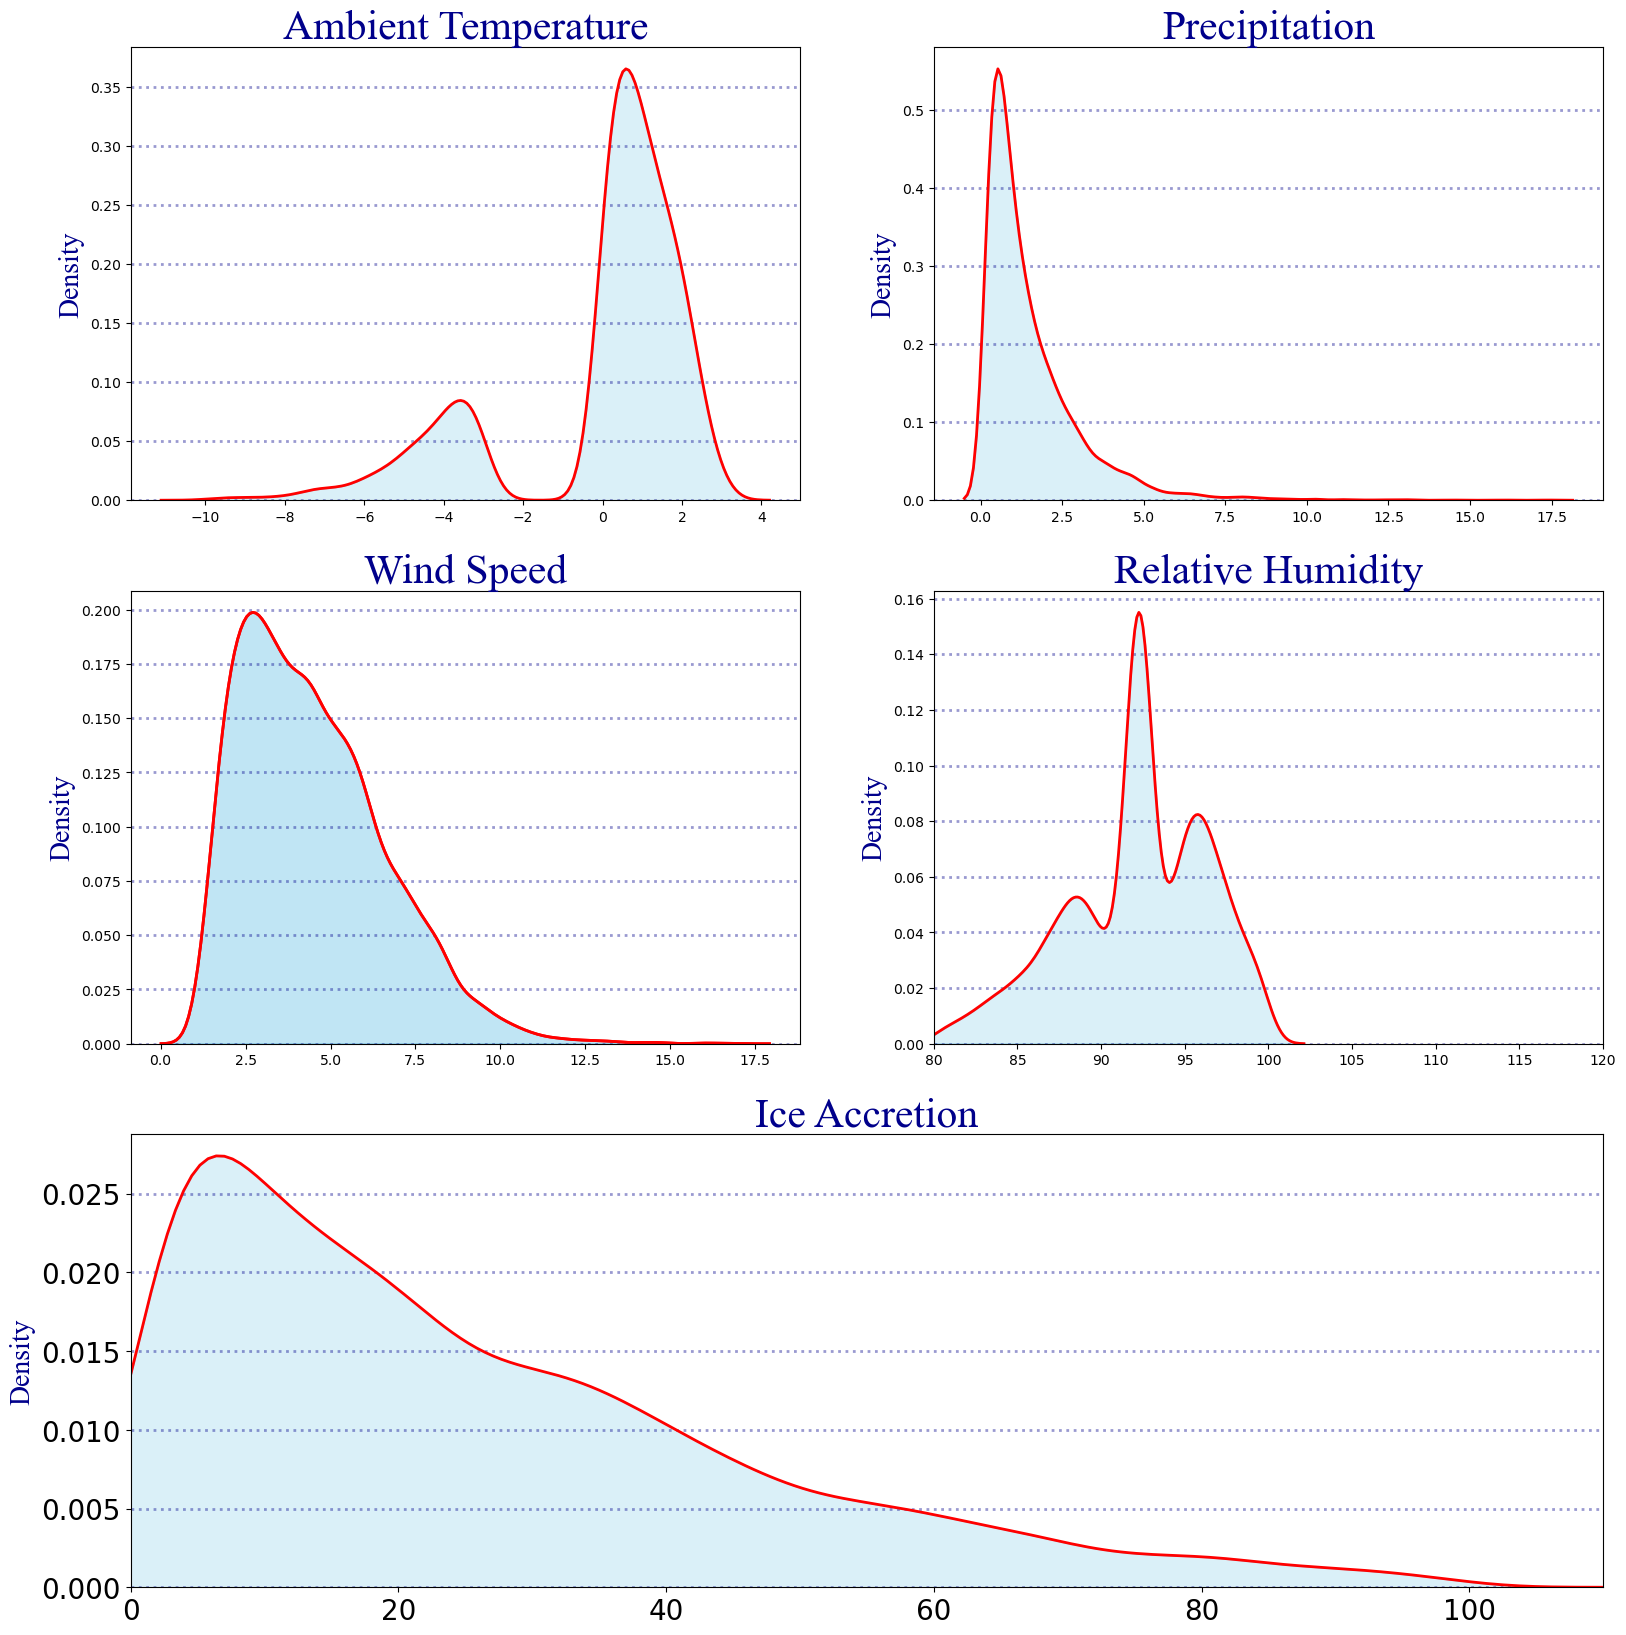

In [56]:
fig, axT = plt.subplots(nrows = 3, ncols = 2, figsize= [19, 20])

ax = axT[0, 0]
ax.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(samples.tmpc, fill=True, color='skyblue', alpha=0.3, ax = ax)
kdeplot(samples.tmpc, color='red', linewidth=2, ax = ax)
ax.set_title('Ambient Temperature', fontsize=30, fontname='times new roman', color='darkblue')
ax.set_ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
ax.set_xlabel('')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = axT[0, 1]
ax.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(samples.p01m, fill=True, color='skyblue', alpha=0.3, ax = ax)
kdeplot(samples.p01m, color='red', linewidth=2, ax = ax)
ax.set_title('Precipitation', fontsize=30, fontname='times new roman', color='darkblue')
ax.set_ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('')


ax = axT[1, 0]
ax.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(samples.sped, fill=True, color='skyblue', alpha=0.3, ax = ax)
kdeplot(samples.sped, color='red', linewidth=2, ax = ax)
ax.set_title('Wind Speed', fontsize=30, fontname='times new roman', color='darkblue')
ax.set_ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('')


ax = axT[1, 1]
ax.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(samples.relh, fill=True, color='skyblue', alpha=0.3, ax = ax)
kdeplot(samples.relh, color='red', linewidth=2, ax = ax)
ax.set_title('Relative Humidity', fontsize=30, fontname='times new roman', color='darkblue')
ax.set_ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlim(80, 120)
ax.set_xlabel('')

ax = axT[1, 0]
ax.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(samples.sped, fill=True, color='skyblue', alpha=0.3, ax = ax)
kdeplot(samples.sped, color='red', linewidth=2, ax = ax)
ax.set_title('Wind Speed', fontsize=30, fontname='times new roman', color='darkblue')
ax.set_ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('')


gs = axT[2, 0].get_gridspec()
# remove the underlying axes
for ax in axT[2, 0:]:
    ax.remove()
axbig = fig.add_subplot(gs[2, 0:])

axbig.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(samples.r01m, fill=True, color='skyblue', alpha=0.3, ax = axbig)
kdeplot(samples.r01m, color='red', linewidth=2, ax = axbig)
axbig.set_title('Ice Accretion', fontsize=30, fontname='times new roman', color='darkblue')
axbig.set_ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
axbig.set_xlabel('')
axbig.set_xlim([0, 110])
# Show the plot
plt.show()

In [ ]:
# Now, we have to fit a 2-hidden layers neural network to our data to be able to perform sensitivity analysis.

In [87]:


X = samples.iloc[:, :-1
                ].to_numpy()
y = samples.iloc[:,  -1].to_numpy().reshape(-1, 1)

scaleX = MinMaxScaler()
scaley = MinMaxScaler()

X = scaleX.fit_transform(X)
y = scaley.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size= 0.15,
                                                   random_state = 123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size=0.15,
                                                 random_state= 123)



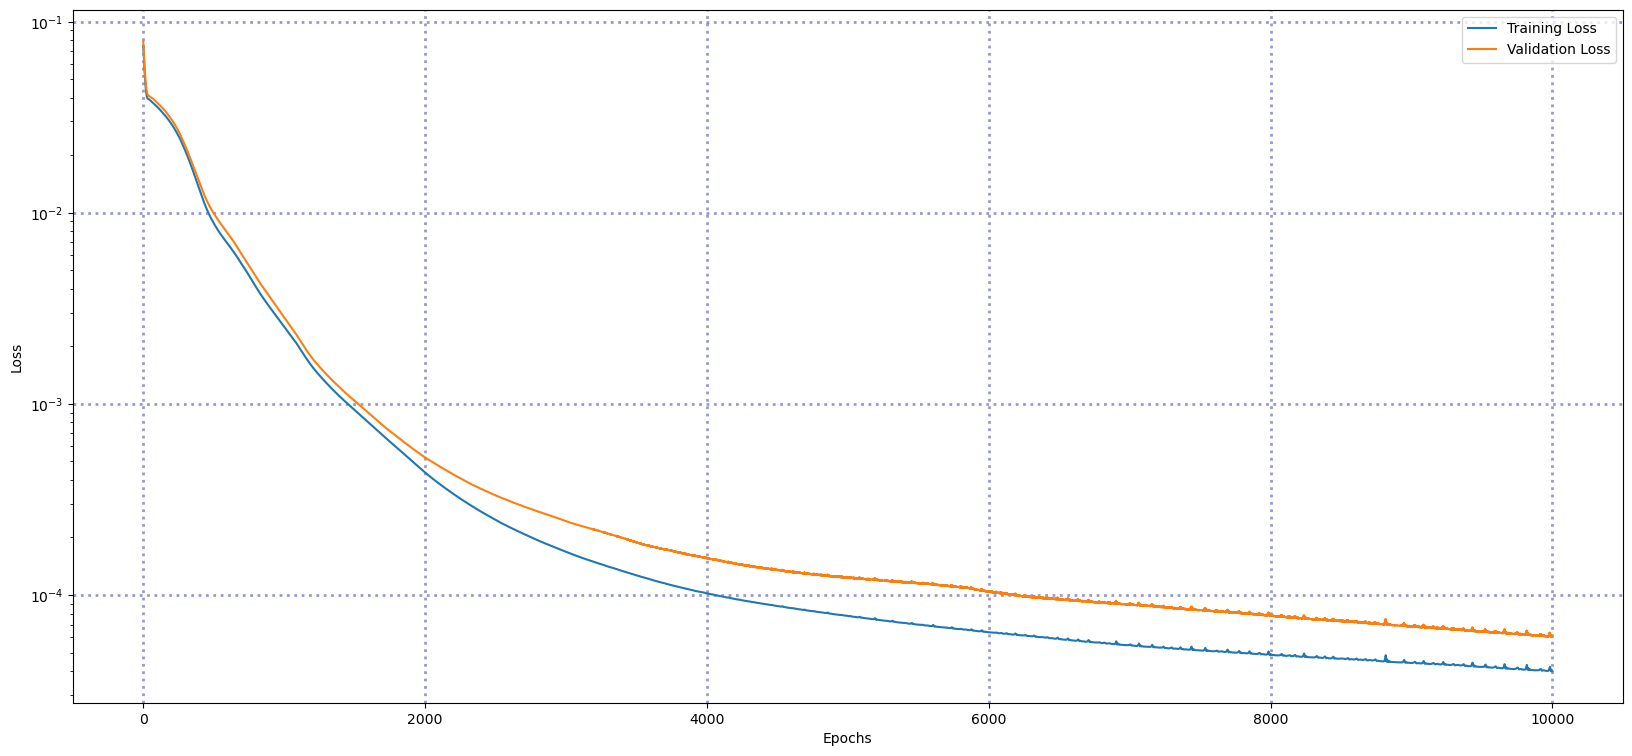

Training Metrics:
MSE: 3.9937520341482013e-05
MAE: 0.00431633647531271
R^2: 0.9990860384522402

Test Metrics:
MSE: 4.3163992813788354e-05
MAE: 0.004535533953458071
R^2: 0.99906989550173

Validation Metrics:
MSE: 6.061757085262798e-05
MAE: 0.004900585860013962
R^2: 0.9986695548793462


In [66]:


# Define the neural network architecture
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(4, 100)#Note that the number of neurons are selected without doing hyperparameter tuning. 
                                    # Therefore, it is possible to have a slightly different sobol indcis if we do tuning.
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create the neural network model
model = NeuralNet()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the number of epochs
epochs = 10_000

# Create empty lists to store the loss values
train_losses = []
val_losses = []

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear the gradients

    # Forward pass
    y_pred = model(X_train)

    # Compute the training loss
    train_loss = criterion(y_pred, y_train)
    train_losses.append(train_loss.item())

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Forward pass for validation set
        y_val_pred = model(X_val)

        # Compute the validation loss
        val_loss = criterion(y_val_pred, y_val)
        val_losses.append(val_loss.item())

# Plot the training and validation loss curves
plt.subplots(1, figsize=[20, 9])
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
plt.grid(lw = 2, color ='darkblue', linestyle=":", alpha = 0.4)
plt.show()

# Convert test data to PyTorch tensor
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Evaluation on training, test, and validation data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Training data evaluation
    y_train_pred = model(X_train)
    train_mse = criterion(y_train_pred, y_train).item()
    train_mae = torch.abs(y_train_pred - y_train).mean().item()
    train_r2 = 1 - train_mse / torch.var(y_train).item()

    # Test data evaluation
    y_test_pred = model(X_test)
    test_mse = criterion(y_test_pred, y_test).item()
    test_mae = torch.abs(y_test_pred - y_test).mean().item()
    test_r2 = 1 - test_mse / torch.var(y_test).item()

       # Validation data evaluation
    y_val_pred = model(X_val)
    val_mse = criterion(y_val_pred, y_val).item()
    val_mae = torch.abs(y_val_pred - y_val).mean().item()
    val_r2 = 1 - val_mse / torch.var(y_val).item()

# Print the evaluation metrics
print("Training Metrics:")
print("MSE:", train_mse)
print("MAE:", train_mae)
print("R^2:", train_r2)
print()
print("Test Metrics:")
print("MSE:", test_mse)
print("MAE:", test_mae)
print("R^2:", test_r2)
print()
print("Validation Metrics:")
print("MSE:", val_mse)
print("MAE:", val_mae)
print("R^2:", val_r2)



In [ ]:
# Now sensitivity analysis should be carried out to identify the most effective parameters.

In [67]:



# Define the input ranges
"""

:param num_vars:   the number of inputs variables in the study
:param names:      Name of paarameters
:param bounds:     lower and upper boundaries of each parameter

"""

problem = {
    'num_vars': 4,
    'names': ['tmpc', 'p01m', 'sped','relh'],
    'bounds': [[samples.tmpc.min(), samples.tmpc.max()], 
               [samples.p01m.min(), samples.p01m.max()],
               [samples.sped.min(), samples.sped.max()],
               [samples.relh.min(), samples.relh.max()]
               ]
}

# Generate the samples using Saltelli's sampling scheme
param_values = saltelli.sample(problem, 10_000, calc_second_order=True)
print(param_values)

# Evaluate the model for each sample
Y = np.zeros([param_values.shape[0]])
for i, params in enumerate(param_values):
    params = scaleX.transform(np.array(params).reshape(1, -1))
    params = torch.Tensor(params)
    outputs = model(params)
    outputs = outputs.detach().numpy()
    outputs = np.array(outputs).reshape(-1, 1)
    outputs = scaley.inverse_transform(outputs)
    
    Y[i] = outputs

# Compute the Sobol indices and print the results
Si = sobol.analyze(problem, Y, calc_second_order=True)



[[-9.90894537  7.10873906 10.96411199 84.22794093]
 [ 2.12206442  7.10873906 10.96411199 84.22794093]
 [-9.90894537  7.34631192 10.96411199 84.22794093]
 ...
 [ 0.95693454  5.30653442  6.74745987 84.50960933]
 [ 0.95693454  5.30653442  2.27033071 87.57260083]
 [ 0.95693454  5.30653442  2.27033071 84.50960933]]


In [68]:
print('1st indices:\n\t', Si['S1'])
print('2nd indices: \n\t', Si['S2'])

print('Total indices:\n\t', Si['ST'])


1st indices:
	 [0.40130782 0.07546751 0.50627104 0.00136169]
2nd indices: 
	 [[            nan  3.10992766e-03  8.56901361e-03 -1.46015131e-04]
 [            nan             nan  2.92146682e-03  5.01293117e-05]
 [            nan             nan             nan -6.99390625e-04]
 [            nan             nan             nan             nan]]
Total indices:
	 [0.41463558 0.08284531 0.51919923 0.00223585]


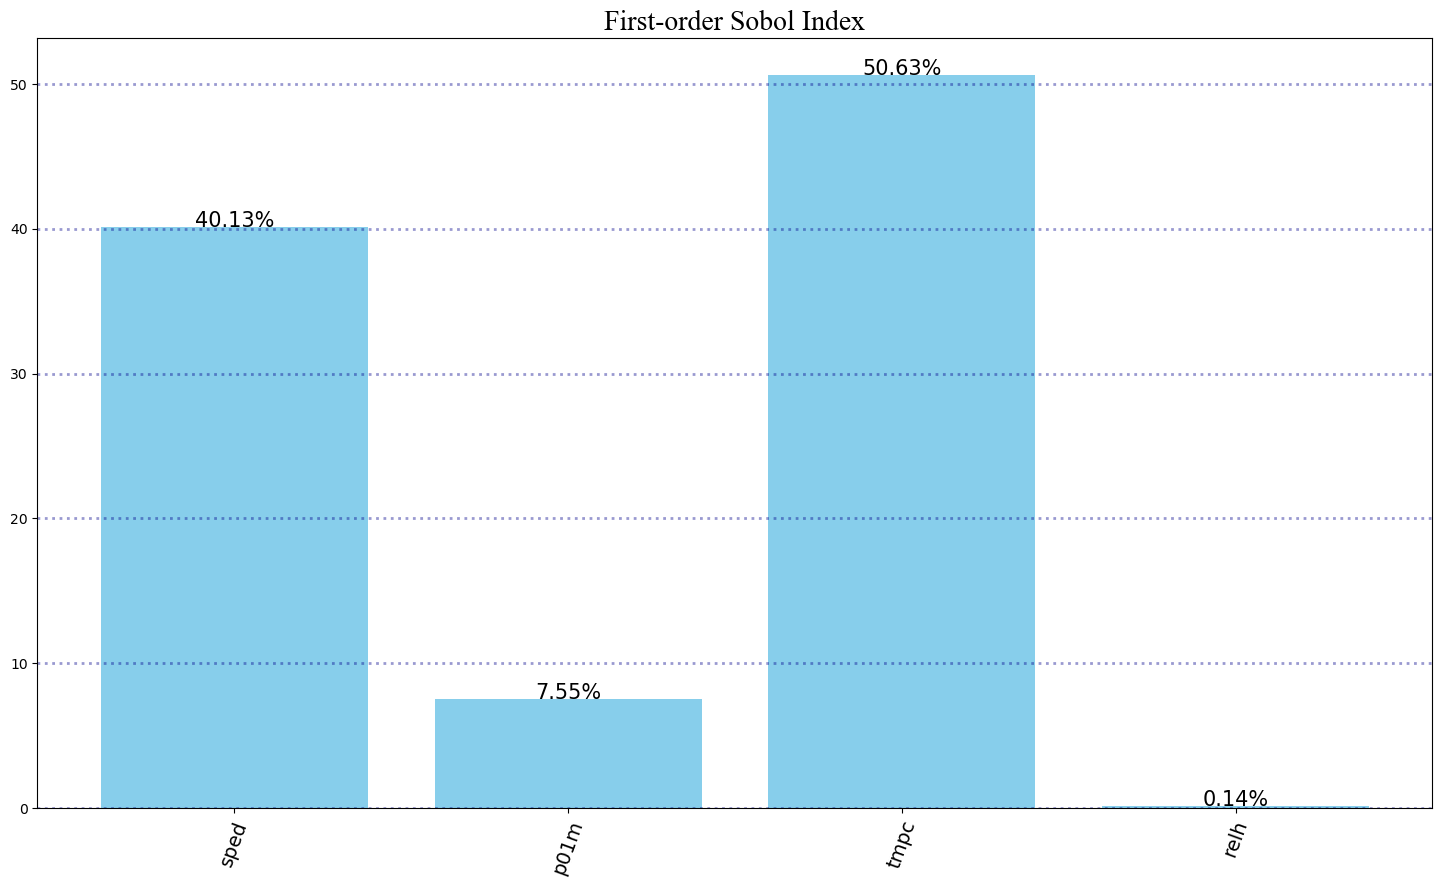

In [69]:

# Set the figure size and the width of the bars
fig, ax = plt.subplots(figsize=(18, 10))
width = 0.8

y = Si['S1']
# Create a bar plot
columns  = ['Ambient Temperature', 'Precipitation', 'Wind speed', 'Relative Humidity']

ax.bar(columns, y*100, width = width, color = 'skyblue')

# Add values to the bars
for i, v in enumerate(y*100):
    ax.text(i, v , str(np.round(v, 2))+'%', ha='center', fontsize = 15)
    
plt.gca().set_xticklabels(samples.columns[:-1], fontsize= 14, rotation = 70)
plt.grid(color ='darkblue', linestyle = ':', alpha = 0.4, lw = 2, axis = 'y')
plt.title('First-order Sobol Index', fontsize = 20 ,fontname = 'Times New Roman')
_ = plt.show()

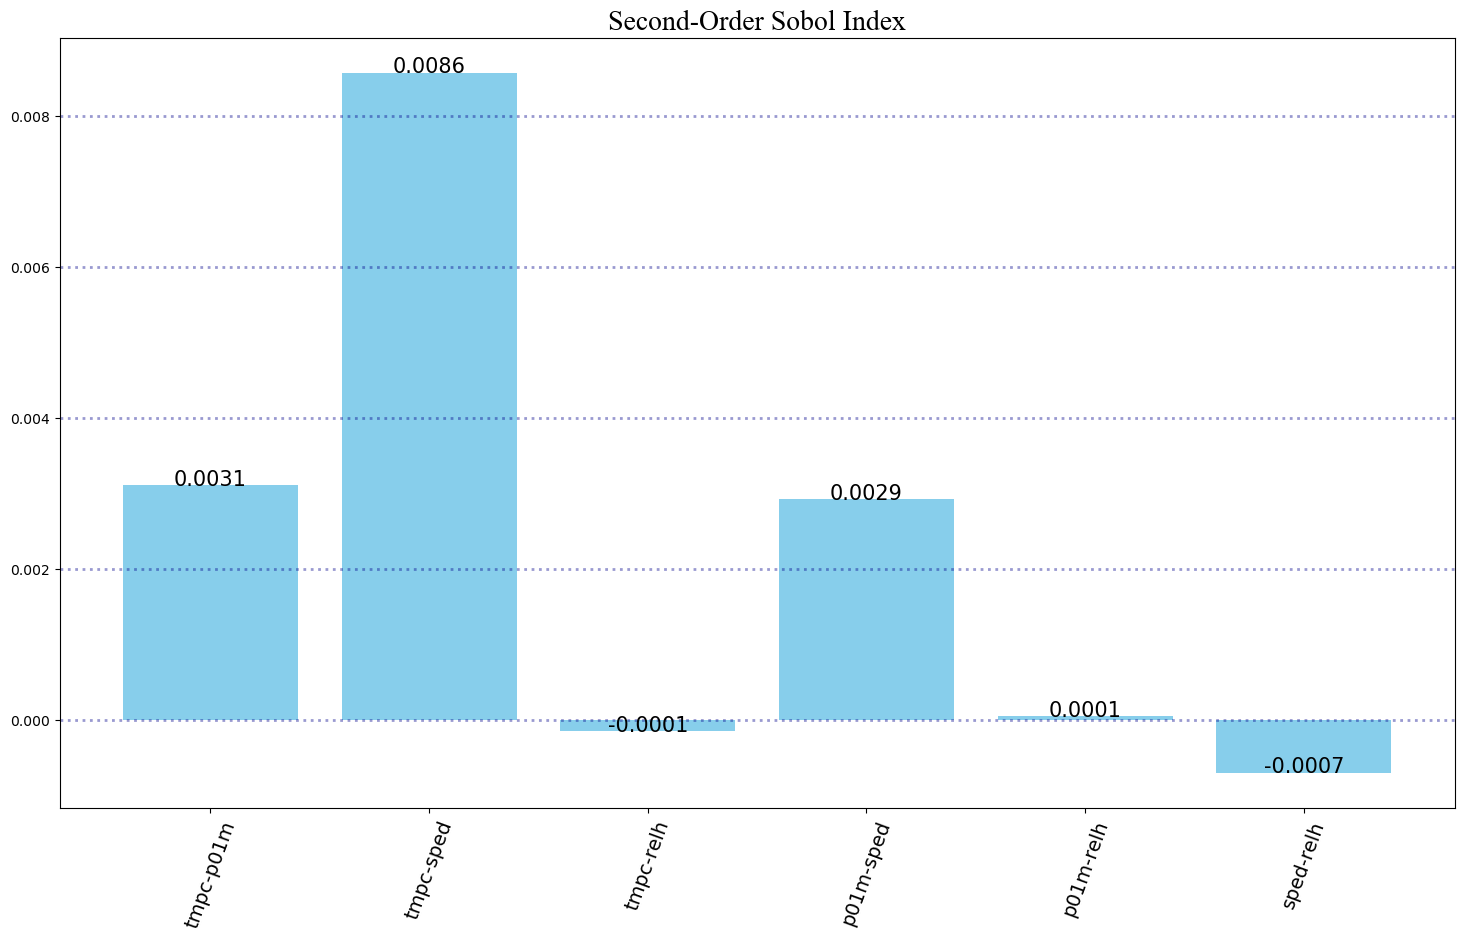

In [70]:
y = Si['S2']

# y = np.nan_to_num(y)

y = pd.DataFrame(y)
colnames = ['tmpc', 'p01m', 'sped', 'relh']
y.columns = colnames
y.index = colnames

y

# Get the indices of the upper triangular part of the DataFrame
rows, cols = np.triu_indices(len(y))

# Create a two-column DataFrame with the row and column indices and their corresponding values
result = pd.DataFrame({'Row-Column': [f'{y.index[row]}-{y.columns[col]}' for row, col in zip(rows, cols)],
                       'Value': [y.iloc[row, col] for row, col in zip(rows, cols)]})
result.dropna(inplace = True)
# Print the resulting DataFrame

y = result.to_numpy()

# Set the figure size and the width of the bars
fig, ax = plt.subplots(figsize=(18, 10))
width = 0.8

# y = np.abs(Si['ST'])
# Create a bar plot
ax.bar(y[:, 0], y[:, 1], width = width, color = 'skyblue')

# Add values to the bars
for i, v in enumerate(y[:, 1]):
    ax.text(i, v , str(np.round(v, 4)), ha='center', fontsize = 15)
    
plt.gca().set_xticklabels(y[:, 0], fontsize= 14, rotation = 70)
plt.grid(color ='darkblue', linestyle = ':', alpha = 0.4, lw = 2, axis = 'y')
plt.title('Second-Order Sobol Index', fontsize = 20 ,fontname = 'Times New Roman')
_ = plt.show()

In [193]:
# The sum of Sobol indices does not necessarily equal 1 because Sobol indices represent
# the proportion of variance in the output of a model that can be attributed to each input variable
# or set of variables.


# While it is true that the sum of all individual Sobol indices associated with each input variable 
# gives an indication of the overall importance of the variables, it does not necessarily sum up to 1.
# The reason for this is that the total output variance can be influenced by factors other than the
# input variables themselves, such as model error or noise.

# In some cases, if the model is highly nonlinear or contains complex interactions between variables,
# the sum of Sobol indices may exceed 1. This occurs when the interactions between variables contribute
# additional variance to the output beyond what can be explained by the individual variables alone.

# Therefore, it is important to interpret Sobol indices as relative measures of importance rather than
# absolute proportions, and the sum of the indices may not always add up to 1.

# In this case, a normalization can be employed to scale the data such that their sum be 1.0

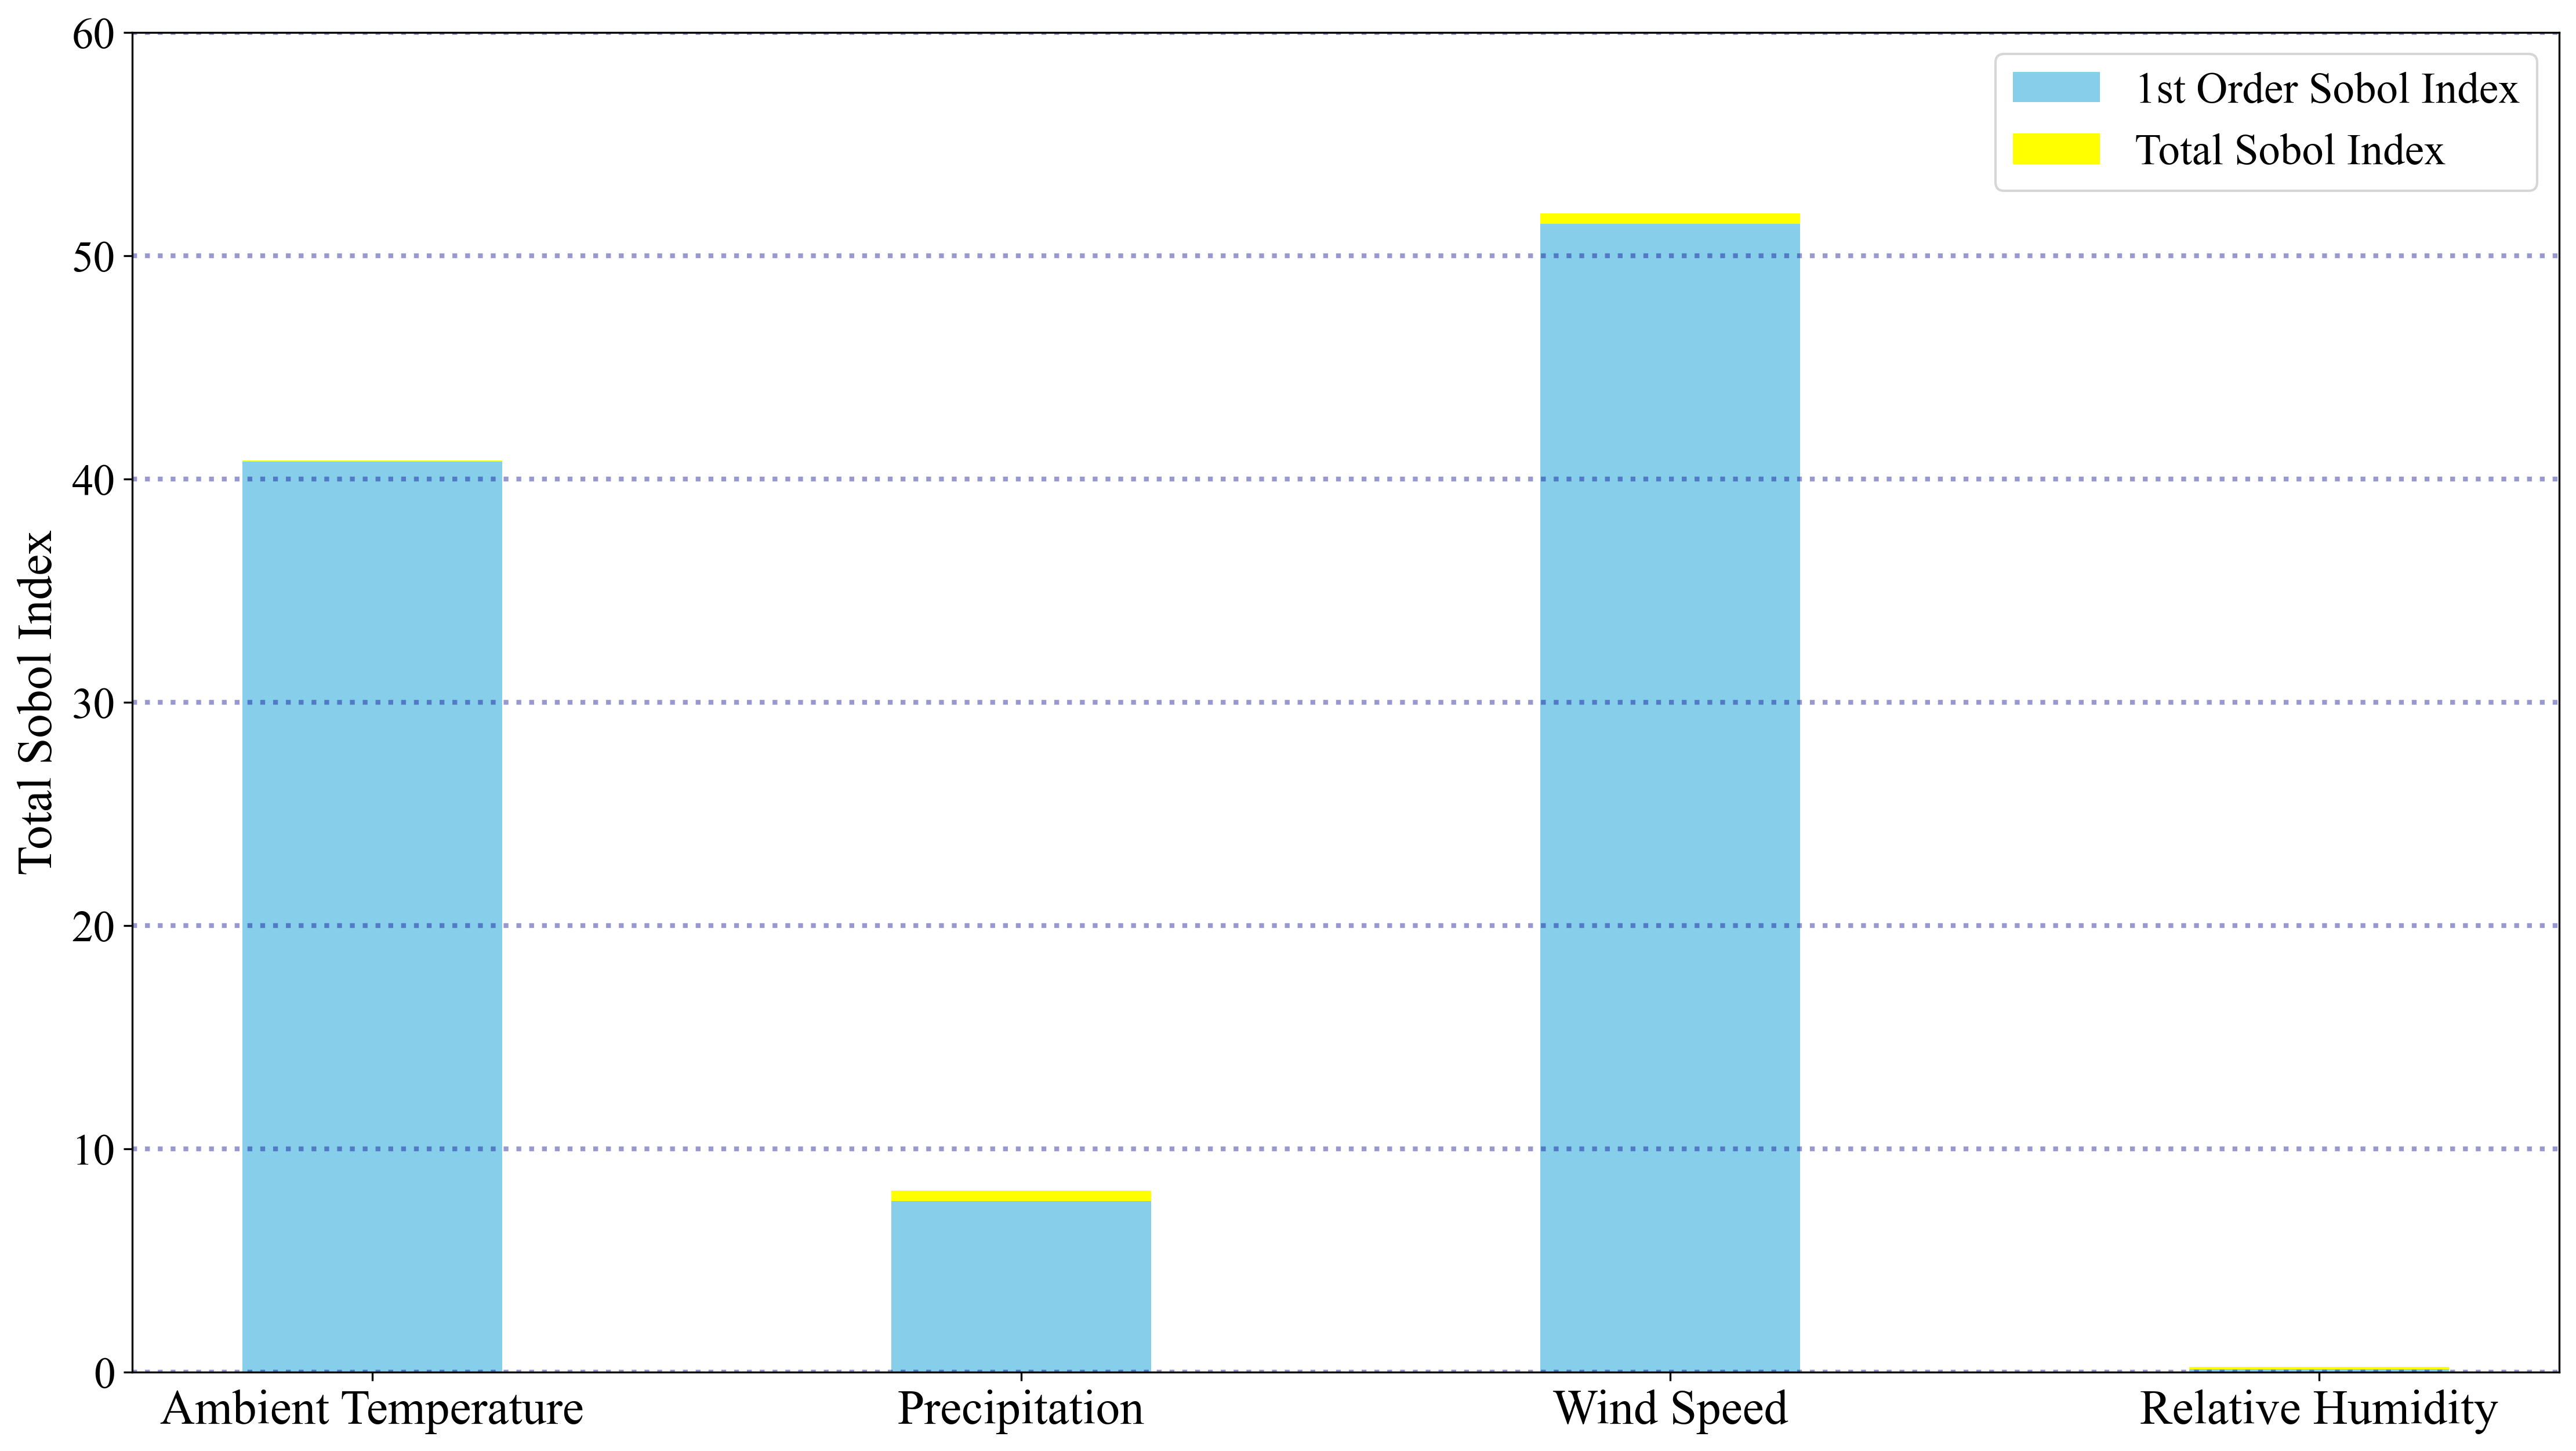

In [72]:
# After normalizations

y = Si['ST']
y1 = Si['S1']

y = y/sum(y)# Set the figure size and the width of the bars
y1 = y1/sum(y1)
diff = y - y1
_, ax = plt.subplots(figsize=(18, 10), dpi = 300)#
width = 0.4

y1 *= 100
diff *= 100
    
# Create a bar plot
columns  = ['Ambient Temperature', 'Precipitation', 'Wind Speed', 'Relative Humidity']
ax.bar(columns, y1, width = width, color = 'skyblue', label = '1st Order Sobol Index')
ax.bar(columns, abs(diff), width = width, color = 'yellow', label = 'Total Sobol Index', bottom=y1)
# Add values to the bars

    
plt.gca().set_xticklabels(columns, fontsize= 20, rotation = 0, fontname = 'times new roman')
plt.grid(color ='darkblue', linestyle = ':', alpha = 0.4, lw = 2, axis = 'y')
ax.set_ylabel('Total Sobol Index', fontsize= 20, rotation = 90, fontname = 'times new roman')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18, fontname='times new roman')
plt.legend(loc='upper right', prop={'family':'times new roman', 'size':18})
plt.ylim([0, 60])

# for i, v in enumerate(Si['ST']/1e10):
#     ax.text(i, v+ 0.5 , str(np.round(v, 2)) + '%', ha='center', fontsize = 18, fontname = 'times new roman')
_ = plt.show()

In [ ]:
# Visualization of the sampled values.

In [73]:
# Signal to noise ratio of the data

SNR = samples.r01m.std()/samples.r01m.mean()

SNR

0.8205653866209152

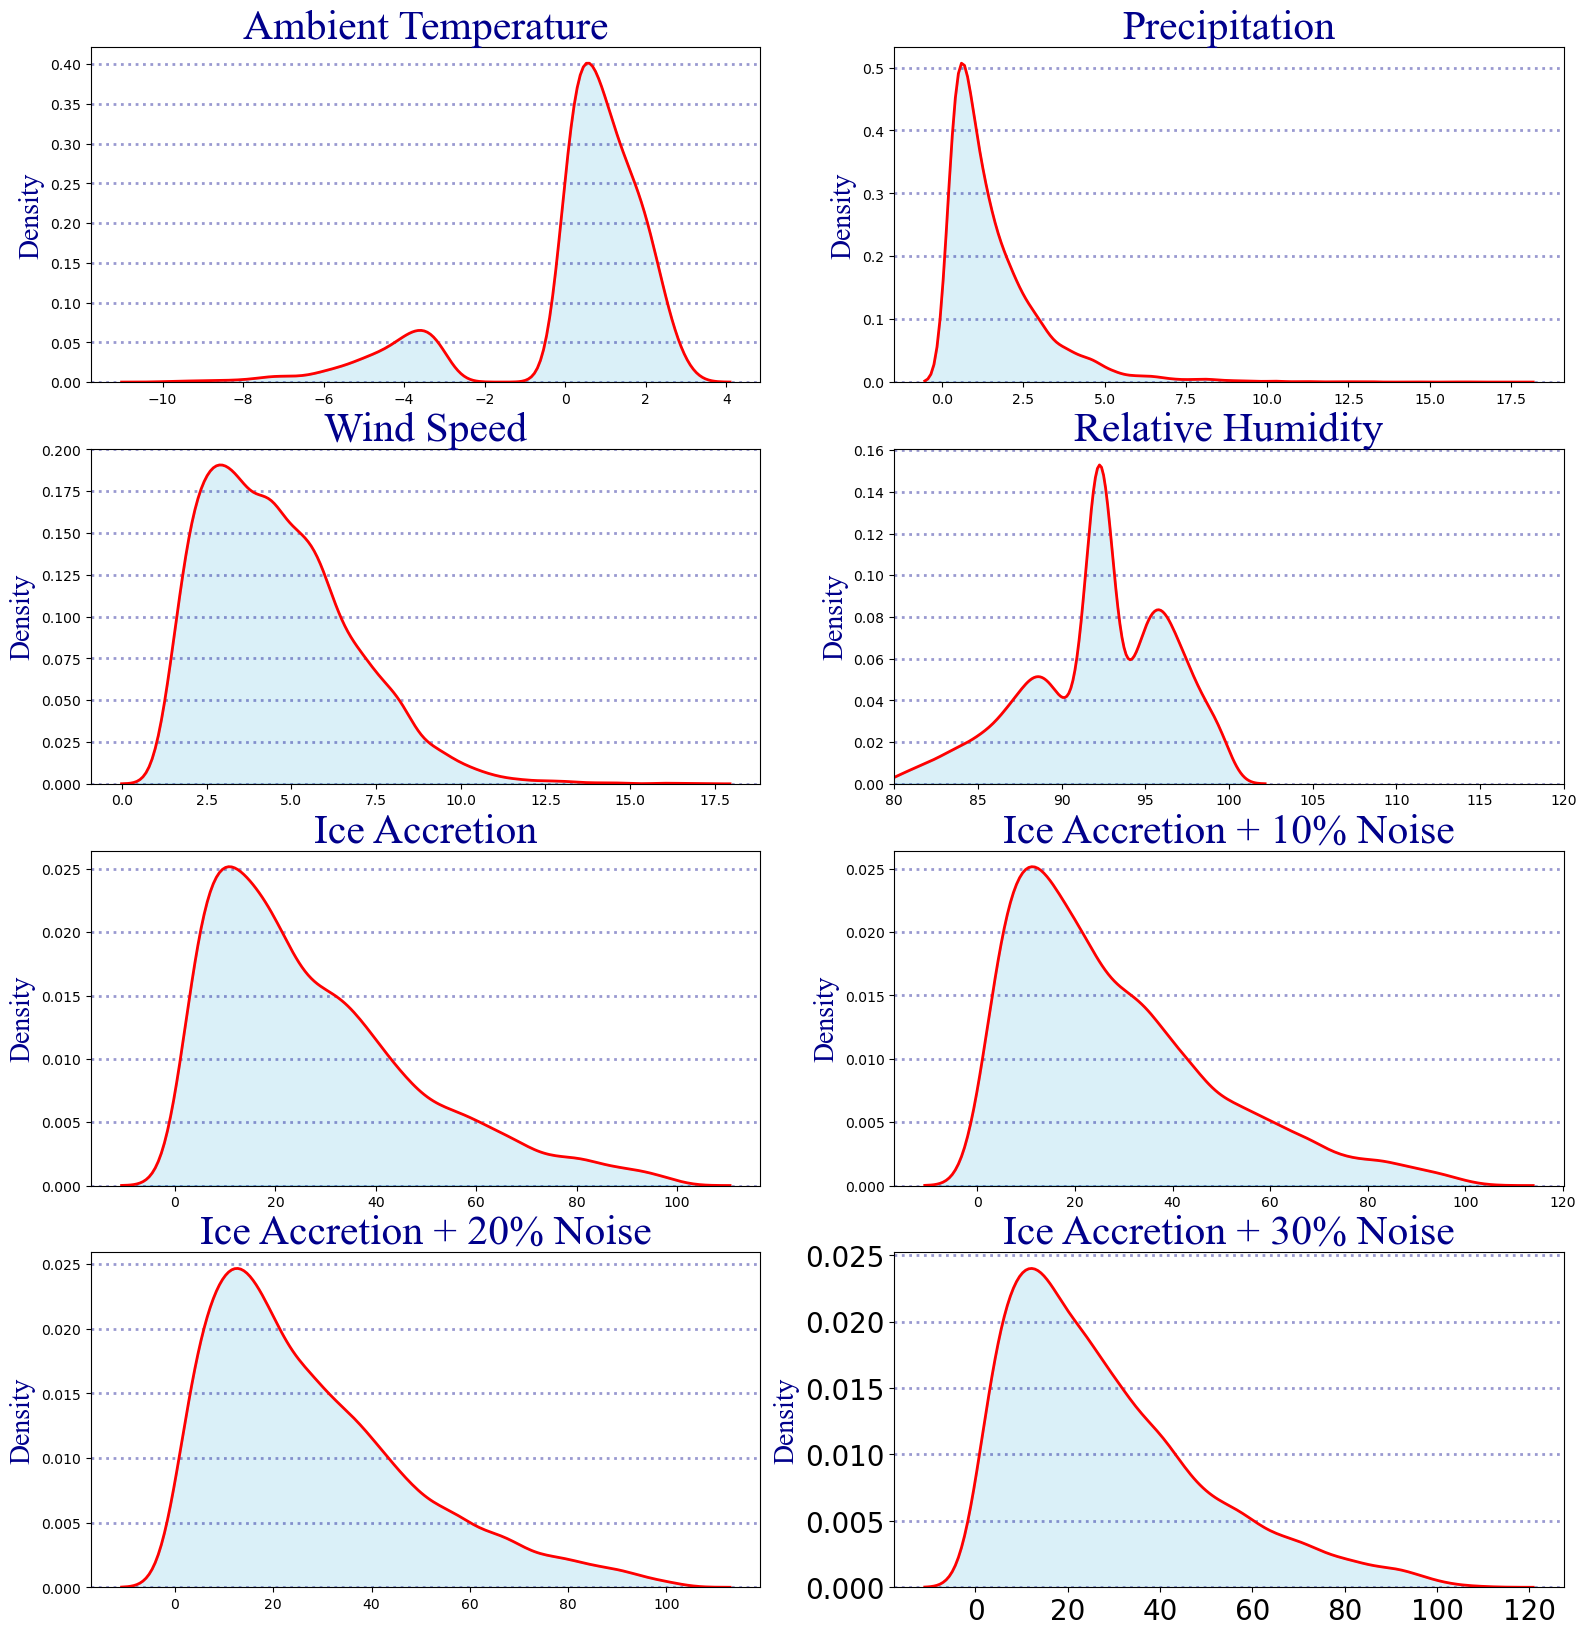

In [75]:
fig, axT = plt.subplots(nrows = 4, ncols = 2, figsize= [19, 20])

ax = axT[0, 0]
ax.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(samples.tmpc, fill=True, color='skyblue', alpha=0.3, ax = ax)
kdeplot(samples.tmpc, color='red', linewidth=2, ax = ax)
ax.set_title('Ambient Temperature', fontsize=30, fontname='times new roman', color='darkblue')
ax.set_ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
ax.set_xlabel('')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = axT[0, 1]
ax.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(samples.p01m, fill=True, color='skyblue', alpha=0.3, ax = ax)
kdeplot(samples.p01m, color='red', linewidth=2, ax = ax)
ax.set_title('Precipitation', fontsize=30, fontname='times new roman', color='darkblue')
ax.set_ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('')

ax = axT[1, 0]
ax.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(samples.sped, fill=True, color='skyblue', alpha=0.3, ax = ax)
kdeplot(samples.sped, color='red', linewidth=2, ax = ax)
ax.set_title('Wind Speed', fontsize=30, fontname='times new roman', color='darkblue')
ax.set_ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('')


ax = axT[1, 1]
ax.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(samples.relh, fill=True, color='skyblue', alpha=0.3, ax = ax)
kdeplot(samples.relh, color='red', linewidth=2, ax = ax)
ax.set_title('Relative Humidity', fontsize=30, fontname='times new roman', color='darkblue')
ax.set_ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlim(80, 120)
ax.set_xlabel('')

ax = axT[2, 0]
ax.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(samples.r01m, fill=True, color='skyblue', alpha=0.3, ax = ax)
kdeplot(samples.r01m, color='red', linewidth=2, ax = ax)
ax.set_title('Ice Accretion', fontsize=30, fontname='times new roman', color='darkblue')
ax.set_ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('')


ax = axT[2, 1]
ax.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(samples.SNR1, fill=True, color='skyblue', alpha=0.3, ax = ax)
kdeplot(samples.SNR1, color='red', linewidth=2, ax = ax)
ax.set_title('Ice Accretion + 10% Noise', fontsize=30, fontname='times new roman', color='darkblue')
ax.set_ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# ax.set_xlim(80, 120)
ax.set_xlabel('')

ax = axT[3, 0]
ax.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(samples.SNR2, fill=True, color='skyblue', alpha=0.3, ax = ax)
kdeplot(samples.SNR2, color='red', linewidth=2, ax = ax)
ax.set_title('Ice Accretion + 20% Noise', fontsize=30, fontname='times new roman', color='darkblue')
ax.set_ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# ax.set_xlim(80, 120)
ax.set_xlabel('')

ax = axT[3, 1]
ax.grid(color='darkblue', alpha= 0.4, lw=2, linestyle=":", axis = 'y')
kdeplot(samples.SNR3, fill=True, color='skyblue', alpha=0.3, ax = ax)
kdeplot(samples.SNR3, color='red', linewidth=2, ax = ax)
ax.set_title('Ice Accretion + 30% Noise', fontsize=30, fontname='times new roman', color='darkblue')
ax.set_ylabel('Density', fontsize=20, color = 'darkblue', fontname = 'times new roman')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# ax.set_xlim(80, 120)
ax.set_xlabel('')

_ = plt.show()

In [97]:
#computing the equivalent ice accretion

In [88]:
df = df[['lon','lat','sped','p01m', 'tmpc','relh']]

In [89]:
df['r01m'] = 0

A_conduct = 435e-6 #conductor ACSR435
D_conduct = (4/np.pi*A_conduct)**0.5 #Diameter of the conductor

ro_air = 101325/(287.058*(273.15 + df.tmpc.to_numpy())) #P_atmosphere/(r_sepcific*T)
ro_w   = 1000 #density of water
d = 25e-6     # Median volume diameter of droplets

mu = 1.8e-5 # variation of absolute viscosity at different temperatures is neglected.

M_sublim = -0.02 #kg/m.h sublimation rate at dry hours
M_meltin = -0.3 #kg/m.h  typical melting rate at dry hours

# in the following lines of code, the ambient temperature is used an the index for distinguishing 
# different types of ice. In addition, the effect of refreezing for wet snow is disregarded.

for row in range(df.shape[0]):

    ro_ice = dens_ice(df.iloc[row, 4])#calculating density of ice
    ro_ice *= 1000 #unit conversion
    
    K = ro_w*d**2/(9*mu*D_conduct) # intertia parameter
    Re = ro_air[row]*d*df.iloc[row, 2]/mu # Reynolds number
    phi = Re**2/K # Langmuir parameter
    
    if df.iloc[row, 4] <= -3: #rime
        

        lwc = 0.067*df.iloc[row, 3]**0.848     # Best model, 1949 
        
        # α1
        A = 1.066*K**(-0.00616)*np.exp(-1.103*K**(-0.688))
        B = 3.641*K**(-0.498)*np.exp(-1.497*K**(-0.694))
        C = 0.00637*(phi - 100)**0.381
        
        alpha1 = A - 0.028- C*(B - 0.0454)
        alpha1 = check_alpha(alpha1)#check for the valid range of alpha
        # α2
        alpha2 = 1.0# No bounce off
        alpha2 = check_alpha(alpha2)#check for the valid range of alpha
        # α3
        alpha3 = 1.0# No dripping
        alpha3 = check_alpha(alpha3)#check for the valid range of alpha
        I = alpha1*alpha2*alpha3*lwc*df.iloc[row, 2]*A_conduct #Mass per unit length
        
        M = I*3600 # total mass during one hour period
        
        M += M_sublim   # Reducing the sublimation
        
        df.iloc[row, -1] = 0.5*(np.sqrt(4/np.pi*M/ro_ice + D_conduct**2) - D_conduct) # calculating the ERE
        
        df.iloc[row, -1] = check_for_ice_values(df.iloc[row, -1]) #check for valid range of ice accretion
        
    elif df.iloc[row, 4] <= 0.0: #glaze
        
        lwc = 0.067*df.iloc[row, 3]**0.848  # Best model, 1949
        
        
        # α1
        A = 1.066*K**(-0.00616)*np.exp(-1.103*K**(-0.688))
        B = 3.641*K**(-0.498)*np.exp(-1.497*K**(-0.694))
        C = 0.00637*(phi - 100)**0.381
        
        alpha1 = A - 0.028- C*(B - 0.0454)
        alpha1 = check_alpha(alpha1)#check for the valid range of alpha
        
        # α2
        alpha2 = 1.0# No bounce off
        alpha2 = check_alpha(alpha2)#check for the valid range of alpha
        # α3
        alpha3 = accre_efficiency(alpha1, alpha2, lwc, df.iloc[row, 2], df.iloc[row, 4])
        
        alpha3 = check_alpha(alpha3)#check for the valid range of alpha
        
        I = alpha1*alpha2*alpha3*lwc*df.iloc[row, 4]*A_conduct #Mass per unit length
        
        M = I*3600 # total mass during one hour period
        
        M += M_sublim  # Reducing the term of sublimation
        
        df.iloc[row, -1] = 0.5*(np.sqrt(4/np.pi*M/ro_ice + D_conduct**2) - D_conduct)  # Calculationg of ERE
        df.iloc[row, -1] = check_for_ice_values(df.iloc[row, -1]) #check for valid range of ice accretion
    else: #wet snow
        
        # α1
        A = 1.066*K**(-0.00616)*np.exp(-1.103*K**(-0.688))
        B = 3.641*K**(-0.498)*np.exp(-1.497*K**(-0.694))
        C = 0.00637*(phi - 100)**0.381
        
        alpha1 = A - 0.028- C*(B - 0.0454)
        alpha1 = check_alpha(alpha1)#check for the valid range of alpha
        # α2
        if df.iloc[row, 4] == 0:
            alpha2 = 1.0
        else:
            alpha2 = 1/(df.iloc[row, 2])**0.5
            
        alpha2 = check_alpha(alpha2)#check for the valid range of alpha
        # α3
        
        vs = 1.7 # The terminal fall speed of wet snowflakes
    
        LWC_wt = df.iloc[row, 3]/vs    # Nyggard et. al        
        
        if df.iloc[row, 2] <1: # For lower wind speed, there is no dripping.
            
            alpha3 = 1.0
        else:
            alpha3 = accre_efficiency(alpha1, alpha2,LWC_wt, df.iloc[row, 2], df.iloc[row, 4])
            
        alpha3 = check_alpha(alpha3)#check for the valid range of alpha
    

        
        I = alpha1*alpha2*alpha3*LWC_wt*df.iloc[row, 2]*A_conduct #Mass per unit length
        
        M = I*3600 # total mass during one hour period
        
        M += M_meltin # Reducing the term of melting
        
        df.iloc[row, -1] = 0.5*(np.sqrt(4/np.pi*M/ro_ice + D_conduct**2) - D_conduct) # Calculation of ERE
        
        df.iloc[row, -1] = check_for_ice_values(df.iloc[row, -1]) #check for valid range of ice accretion
        

df.fillna(0,
          inplace = True)

df = df.loc[df.r01m >0] #excluding records without ice accretion

df.iloc[:, -1] *= 1000 #unit conversion

df

,lon,lat,sped,p01m,tmpc,relh,r01m
1,-93.0661,34.0998,5.834133,0.25,0.61,81.30,3.738503
3,-93.0661,34.0998,5.834133,1.02,0.61,91.51,18.599091
6,-93.0661,34.0998,4.773381,3.56,2.22,96.49,41.804284
7,-93.0661,34.0998,3.712630,6.10,2.22,96.49,54.013424
8,-93.0661,34.0998,4.243006,1.52,1.72,95.71,22.389586
...,...,...,...,...,...,...,...
5374,-94.3070,36.2820,5.834133,0.76,0.61,91.51,14.537411
5376,-94.3070,36.2820,8.486011,1.52,-8.28,87.38,14.389558
5377,-94.3070,36.2820,7.425260,0.25,-8.89,87.32,3.615840
5378,-94.3070,36.2820,5.834133,0.25,-7.78,91.72,2.759124


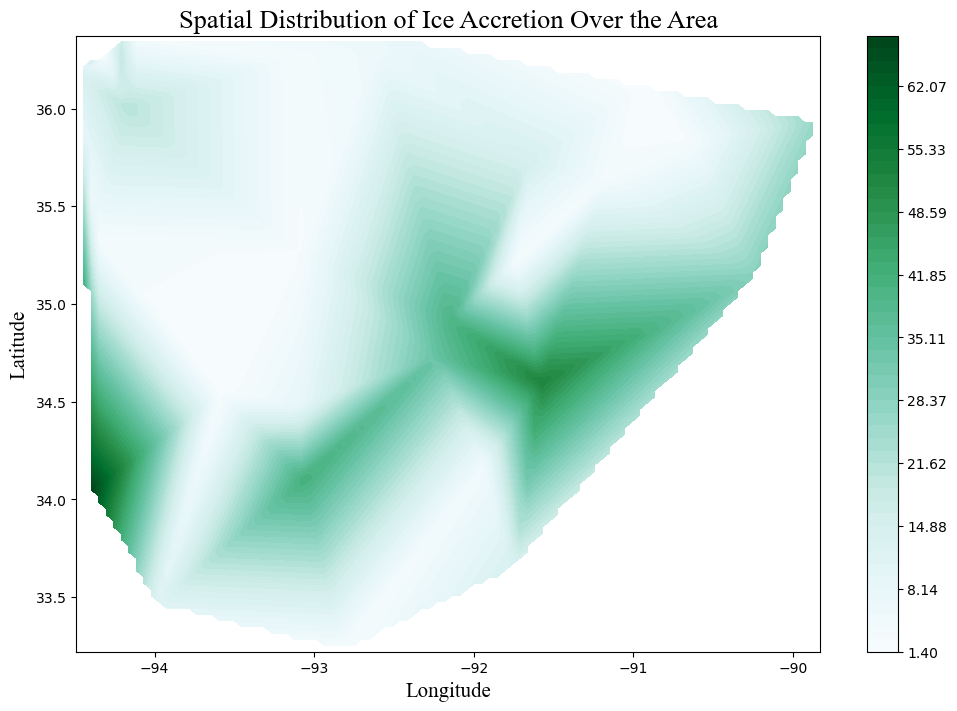

In [126]:
from scipy.interpolate import griddata

# Assuming your dataframe is named 'df'
x = df['lon'].values
y = df['lat'].values
z = df['r01m'].values

# Remove any NaN or Inf values from the data
valid_indices = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x = x[valid_indices]
y = y[valid_indices]
z = z[valid_indices]

# Create a grid of points using the data range
X, Y = np.meshgrid(np.linspace(min(x), max(x), 100),
                   np.linspace(min(y), max(y), 100))

# Perform linear interpolation
Z = griddata((x, y), z, (X, Y), method='linear')

# Determine the contour levels
levels = np.linspace(np.nanmin(Z), np.nanmax(Z), 50)

# Create a figure and an axis for the contour plot
fig, ax = plt.subplots(figsize=(12, 8))

# Create the contour plot
contour = ax.contourf(X, Y, Z, levels, cmap='BuGn')

# Add a colorbar
colorbar = fig.colorbar(contour)

# Set labels and title
ax.set_xlabel('Longitude',
            fontname='times new roman', fontsize=15)
ax.set_ylabel('Latitude',
            fontname='times new roman', fontsize=15)
ax.set_title('Spatial Distribution of Ice Accretion Over the Area',
            fontname='times new roman', fontsize=19)

# Show the plot
plt.show()

In [127]:
filename='used_dataset.pkl'
# Get the current working directory
current_path = os.getcwd()

# Construct the absolute file path
file_path = os.path.join(current_path, filename)

# Open the file in binary write mode
with open(file_path, 'wb') as file:
    # Use pickle to dump the parameter into the file
    pickle.dump(samples, file)

print(f"Parameter saved to {file_path}.")

Parameter saved to /Users/matt/Desktop/ENCS6181/Project/metaheuristic opt/used_dataset.pkl.


In [90]:
df

,lon,lat,sped,p01m,tmpc,relh,r01m
1,-93.0661,34.0998,5.834133,0.25,0.61,81.30,3.738503
3,-93.0661,34.0998,5.834133,1.02,0.61,91.51,18.599091
6,-93.0661,34.0998,4.773381,3.56,2.22,96.49,41.804284
7,-93.0661,34.0998,3.712630,6.10,2.22,96.49,54.013424
8,-93.0661,34.0998,4.243006,1.52,1.72,95.71,22.389586
...,...,...,...,...,...,...,...
5374,-94.3070,36.2820,5.834133,0.76,0.61,91.51,14.537411
5376,-94.3070,36.2820,8.486011,1.52,-8.28,87.38,14.389558
5377,-94.3070,36.2820,7.425260,0.25,-8.89,87.32,3.615840
5378,-94.3070,36.2820,5.834133,0.25,-7.78,91.72,2.759124


In [210]:


X = df.iloc[:, 2:-2]
y = df.iloc[:, -1].to_numpy().reshape(-1,1)

#splitting the dataset into training, testing, and validation groups
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size= 0.2,
                                                    random_state = 123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size= 0.2,
                                                    random_state = 123)



# Modeling

In [233]:
# Least squre

In [193]:
# herein, we used LineaRegression function from scikit-learn package for doing least square regression.
start = time()
Lin_Model = LinearRegression(n_jobs=-1)

Lin_Model.fit(X_train, y_train)

print(f'{"Runtime:":<20s} {time()-start:.2f} sec.')

Runtime:             0.01 sec.


In [194]:
Pred_Train = Lin_Model.predict(X_train) 
Pred_Test  = Lin_Model.predict(X_test)
Pred_Val   = Lin_Model.predict(X_val)

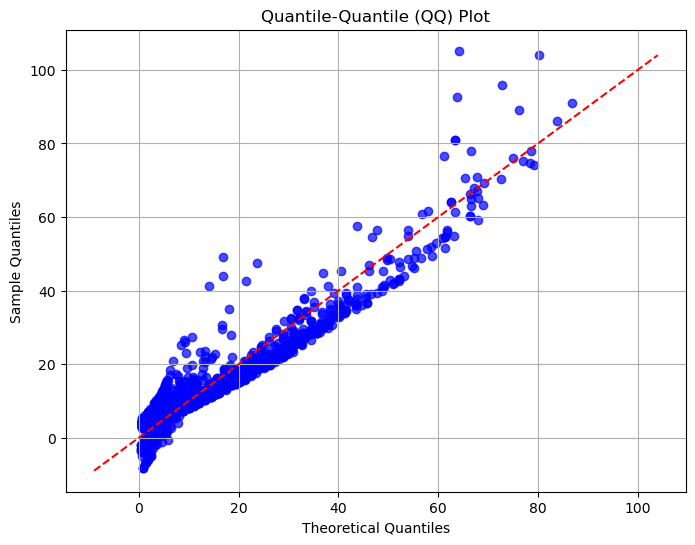

In [195]:

# Plot the QQ plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train, Pred_Train, c='b', alpha=0.7)
plt.plot([-9, 104], [-9, 104], color='red', linestyle='--')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Quantile-Quantile (QQ) Plot')
plt.grid(True)
plt.show()


In [133]:

# Calculate evaluation metrics for training set
mse_train = mse(y_train, Pred_Train)
mae_train = mae(y_train, Pred_Train)
mape_train= mape(y_train, Pred_Train)
r2_train  = r2(y_train, Pred_Train)

# Calculate evaluation metrics for testing set
mse_test = mse(y_test, Pred_Test)
mae_test = mae(y_test, Pred_Test)
mape_test= mape(y_test, Pred_Test)
r2_test  = r2(y_test, Pred_Test)


# Calculate evaluation metrics for validation set
mse_val = mse(y_val, Pred_Val)
mae_val = mae(y_val, Pred_Val)
mape_val= mape(y_val, Pred_Val)
r2_val  = r2(y_val, Pred_Val)


# Format metrics and print them
print(f"{'Metric':<10s} {'Training Set':<15s} {'Testing Set':<15s}{'Validation Set':<15s}")
print(f"{'======':<10s} {'============':<15s} {'===========':<15s}{'==============':<15s}\n")
print(f"{'MSE':<10s} {mse_train:<15.2f} {mse_test:<15.2f} {mse_val:<15.2f}")
print(f"{'MAE':<10s} {mae_train:<15.2f} {mae_test:<15.2f} {mae_val:<15.2f}")
print(f"{'MAPE':<10s} {mape_train:<15.2f} {mape_test:<15.2f} {mape_val:<15.2f}")
print(f"{'R2(%)':<10s} {r2_train:<15.3f} {r2_test:<15.3f} {r2_val:<15.3f}")
print(f"\n{'======':<10s} {'============':<15s} {'===========':<15s}{'==============':<15s}\n")

Metric     Training Set    Testing Set    Validation Set 
======     ============    ===========    ============== 

MSE        22.60           22.20           30.94          
MAE        3.56            3.66            3.68           
MAPE       0.85            0.84            0.84           
R2(%)      0.903           0.885           0.854          

======     ============    ===========    ============== 



In [134]:
#k nearest neighborhood

In [211]:
# Define MinMaxScaler objects
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Apply scaling to X_train, X_test, and X_val
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled  = X_scaler.transform(X_test)
X_val_scaled   = X_scaler.transform(X_val)

# Apply scaling to y_train, y_test, and y_val
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1))
y_val_scaled   = y_scaler.transform(y_val.reshape(-1, 1))

# Flatten the scaled y arrays
y_train_scaled = y_train_scaled.flatten()
y_test_scaled  = y_test_scaled.flatten()
y_val_scaled   = y_val_scaled.flatten()

In [135]:
# Define the objective function for Optuna optimization
def objective(trial):
    k = trial.suggest_int("k", 1, 100)  # Hyperparameter: Number of neighbors

    # Create and fit the K-Nearest Neighbor model
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_scaled)

    # Make predictions on the validation set
    y_pred_train = knn.predict(X_train_scaled)
    y_pred_test  = knn.predict(X_test_scaled)
    y_pred_val   = knn.predict(X_val_scaled)
    
    # Calculate and return the mean squared error (MSE) as the objective value
    MSE_train = mse(y_train_scaled, y_pred_train)
    MSE_test = mse(y_test_scaled, y_pred_test)
    MSE_val = mse(y_val_scaled, y_pred_val)

    return MSE_val + MSE_test + MSE_val

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=-1)

# Retrieve the best hyperparameters
best_params = study.best_params
best_k = best_params["k"]

print(f"{'Best Number of Neighbors:':<15s} {best_k:.0f}")

[I 2023-06-21 11:22:34,746] A new study created in memory with name: no-name-f1a11c82-c516-45ab-ad2c-fc823fe05a22
[I 2023-06-21 11:22:34,784] Trial 1 finished with value: 0.0034958796145879117 and parameters: {'k': 21}. Best is trial 1 with value: 0.0034958796145879117.
[I 2023-06-21 11:22:34,817] Trial 7 finished with value: 0.0034958796145879117 and parameters: {'k': 21}. Best is trial 1 with value: 0.0034958796145879117.
[I 2023-06-21 11:22:34,823] Trial 5 finished with value: 0.002868325616910027 and parameters: {'k': 15}. Best is trial 5 with value: 0.002868325616910027.
[I 2023-06-21 11:22:34,824] Trial 2 finished with value: 0.0038806895359858027 and parameters: {'k': 25}. Best is trial 5 with value: 0.002868325616910027.
[I 2023-06-21 11:22:34,826] Trial 6 finished with value: 0.004691786803355511 and parameters: {'k': 35}. Best is trial 5 with value: 0.002868325616910027.
[I 2023-06-21 11:22:34,827] Trial 0 finished with value: 0.010863363786643767 and parameters: {'k': 91}. B

[I 2023-06-21 11:22:35,155] Trial 51 finished with value: 0.0026914889973230875 and parameters: {'k': 1}. Best is trial 15 with value: 0.0019105245703445214.
[I 2023-06-21 11:22:35,161] Trial 53 finished with value: 0.0026914889973230875 and parameters: {'k': 1}. Best is trial 15 with value: 0.0019105245703445214.
[I 2023-06-21 11:22:35,164] Trial 55 finished with value: 0.0026914889973230875 and parameters: {'k': 1}. Best is trial 15 with value: 0.0019105245703445214.
[I 2023-06-21 11:22:35,197] Trial 54 finished with value: 0.011496989948048847 and parameters: {'k': 97}. Best is trial 15 with value: 0.0019105245703445214.
[I 2023-06-21 11:22:35,229] Trial 60 finished with value: 0.0025878595076668995 and parameters: {'k': 9}. Best is trial 15 with value: 0.0019105245703445214.
[I 2023-06-21 11:22:35,231] Trial 57 finished with value: 0.007146111281646064 and parameters: {'k': 59}. Best is trial 15 with value: 0.0019105245703445214.
[I 2023-06-21 11:22:35,234] Trial 56 finished with v

Best Number of Neighbors: 3


In [136]:
# Create and fit the K-Nearest Neighbor model with the best hyperparameters
start = time()

knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train_scaled)
print(f'{"Runtime:":<20s} {time()-start:.9f} sec.\n')

# Make predictions on the training, testing, and validation sets
y_pred_train_scaled = knn.predict(X_train_scaled)
y_pred_test_scaled = knn.predict(X_test_scaled)
y_pred_val_scaled = knn.predict(X_val_scaled)

# Transform the predictions back to the original scale
y_pred_train = y_scaler.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()
y_pred_test = y_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
y_pred_val = y_scaler.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).flatten()

# Calculate metrics for the training set
mse_train = mse(y_train, y_pred_train)
mae_train = mae(y_train, y_pred_train)
mape_train=mape(y_train, y_pred_train)
r2_train = r2(y_train, y_pred_train)

# Calculate metrics for the testing set
mse_test = mse(y_test, y_pred_test)
mae_test = mae(y_test, y_pred_test)
mape_test= mape(y_test, y_pred_test)
r2_test = r2(y_test, y_pred_test)

# Calculate metrics for the validation set
mse_val = mse(y_val, y_pred_val)
mae_val = mae(y_val, y_pred_val)
mape_val=mape(y_val, y_pred_val)
r2_val = r2(y_val, y_pred_val)




# Format metrics and print them
print(f"{'Metric':<10s} {'Training Set':<15s} {'Testing Set':<15s}{'Validation Set':<15s}")
print(f"{'======':<10s} {'============':<15s} {'===========':<15s}{'==============':<15s}\n")
print(f"{'MSE':<10s} {mse_train:<15.2f} {mse_test:<15.2f} {mse_val:<15.2f}")
print(f"{'MAE':<10s} {mae_train:<15.2f} {mae_test:<15.2f} {mae_val:<15.2f}")
print(f"{'MAPE':<10s} {mape_train:<15.2f} {mape_test:<15.2f} {mape_val:<15.2f}")
print(f"{'R2(%)':<10s} {r2_train:<15.2f} {r2_test:<15.2f} {r2_val:<15.2f}")
print(f"\n{'======':<10s} {'============':<15s} {'===========':<15s}{'==============':<15s}\n")

Runtime:             0.000905275 sec.

Metric     Training Set    Testing Set    Validation Set 
======     ============    ===========    ============== 

MSE        1.48            3.53            5.37           
MAE        0.64            1.02            1.09           
MAPE       0.07            0.12            0.13           
R2(%)      0.99            0.98            0.97           

======     ============    ===========    ============== 



In [240]:
# SVR

In [137]:
# Define the objective function for Optuna optimization
def objective(trial):
    C = trial.suggest_loguniform("C", 1e-3, 1e3)  # Hyperparameter: Regularization parameter
    epsilon = trial.suggest_loguniform("epsilon", 1e-3, 1e1)  # Hyperparameter: Epsilon for epsilon-insensitive loss
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly"])  # Hyperparameter: Kernel function
    degree = trial.suggest_int("degree", 1, 5)  # Hyperparameter: Degree for polynomial kernel

    # Create and fit the Support Vector Regression model
    svm = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree)
    svm.fit(X_train_scaled, y_train_scaled)
    
    # Make predictions on the validation set
    y_pred_train = svm.predict(X_train_scaled)

    # Calculate and return the mean squared error (MSE) as the objective value
    MSE_train = mse(y_train_scaled, y_pred_train)

    return MSE_train


# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, n_jobs=-1)

# Retrieve the best hyperparameters
best_params = study.best_params
best_C = best_params["C"]
best_epsilon = best_params["epsilon"]
best_kernel = best_params["kernel"]
best_degree = best_params["degree"]


[I 2023-06-21 11:23:19,102] A new study created in memory with name: no-name-06b16c88-7114-48b5-9263-407449f2819e
[I 2023-06-21 11:23:19,120] Trial 1 finished with value: 0.14747352664242755 and parameters: {'C': 645.9303347368941, 'epsilon': 1.6666134472354006, 'kernel': 'linear', 'degree': 4}. Best is trial 1 with value: 0.14747352664242755.
[I 2023-06-21 11:23:19,123] Trial 5 finished with value: 0.14747352664242755 and parameters: {'C': 0.07902085784497326, 'epsilon': 0.801400548574616, 'kernel': 'linear', 'degree': 5}. Best is trial 1 with value: 0.14747352664242755.
[I 2023-06-21 11:23:19,127] Trial 6 finished with value: 0.14747352664242755 and parameters: {'C': 6.9037264819670074, 'epsilon': 4.895972868865698, 'kernel': 'linear', 'degree': 3}. Best is trial 1 with value: 0.14747352664242755.
[I 2023-06-21 11:23:19,151] Trial 10 finished with value: 0.04410688676705069 and parameters: {'C': 0.003941676499958849, 'epsilon': 0.2895022479662111, 'kernel': 'poly', 'degree': 3}. Best

In [138]:
# Format and print the best hyperparameters
print("Best Hyperparameters:")
print(f"{'Parameter':<20s} {'Value'}")
print(f"{'=========':<18s} {'=========':<15s}")

print(f"{'C':<20s} {best_C:.2f}")
print(f"{'Epsilon':<20s} {best_epsilon:.2f}")
print(f"{'Kernel':<20s} {best_kernel}")
print(f"{'Degree':<20s} {best_degree}")
print(f"{'=========':<18s} {'=========':<15s}")


Best Hyperparameters:
Parameter            Value
=========          =========      
C                    282.42
Epsilon              0.00
Kernel               rbf
Degree               2
=========          =========      


In [139]:
start = time()
# Create and fit the Support Vector Regression model with the best hyperparameters
svm = SVR(C=best_C, epsilon=best_epsilon, kernel=best_kernel, degree=best_degree)
svm.fit(X_train_scaled, y_train_scaled)

# Make predictions on the training, testing, and validation sets
y_pred_train_scaled = svm.predict(X_train_scaled)
y_pred_test_scaled = svm.predict(X_test_scaled)
y_pred_val_scaled = svm.predict(X_val_scaled)

# Transform the predictions back to the original scale
y_pred_train = y_scaler.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()
y_pred_test = y_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
y_pred_val = y_scaler.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).flatten()


# Calculate metrics for the training set
mse_train = mse(y_train, y_pred_train)
mae_train = mae(y_train, y_pred_train)
mape_train=mape(y_train, y_pred_train)
r2_train = r2(y_train, y_pred_train)

# Calculate metrics for the testing set
mse_test = mse(y_test, y_pred_test)
mae_test = mae(y_test, y_pred_test)
mape_test= mape(y_test, y_pred_test)
r2_test = r2(y_test, y_pred_test)

# Calculate metrics for the validation set
mse_val = mse(y_val, y_pred_val)
mae_val = mae(y_val, y_pred_val)
mape_val=mape(y_val, y_pred_val)
r2_val = r2(y_val, y_pred_val)



print(f'run time = {time()-start}')
# Format metrics and print them
print(f"{'Metric':<10s} {'Training Set':<15s} {'Testing Set':<15s}{'Validation Set':<15s}")
print(f"{'======':<10s} {'============':<15s} {'===========':<15s}{'==============':<15s}\n")
print(f"{'MSE':<10s} {mse_train:<15.2f} {mse_test:<15.2f} {mse_val:<15.2f}")
print(f"{'MAE':<10s} {mae_train:<15.2f} {mae_test:<15.2f} {mae_val:<15.2f}")
print(f"{'MAPE':<10s} {mape_train:<15.2f} {mape_test:<15.2f} {mape_val:<15.2f}")
print(f"{'R2(%)':<10s} {r2_train:<15.2f} {r2_test:<15.2f} {r2_val:<15.2f}")
print(f"\n{'======':<10s} {'============':<15s} {'===========':<15s}{'==============':<15s}\n")

run time = 7.993114948272705
Metric     Training Set    Testing Set    Validation Set 
======     ============    ===========    ============== 

MSE        0.08            0.21            3.91           
MAE        0.19            0.25            0.34           
MAPE       0.04            0.04            0.05           
R2(%)      1.00            1.00            0.98           

======     ============    ===========    ============== 



In [185]:
# Obtain the number of support vectors
num_support_vectors = svm.n_support_
print("Number of support vectors:", num_support_vectors)

Number of support vectors: [943]


In [186]:
# Check the kernel used
kernel = svm.kernel
print("Kernel used:", kernel)

# Determine convexity
if kernel == 'linear':
    print("Convex: Yes")
else:
    print("Convex: No")


Kernel used: rbf
Convex: No


In [244]:
# ANN

In [179]:
# Define the objective function for Optuna
def objective(trial):
    # Sample the hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    
    # Create the MLPRegressor model
    model = MLPRegressor(hidden_layer_sizes=(hidden_size,),
                         activation='relu',
                         solver='adam',
                         learning_rate_init=learning_rate,
                         random_state=42)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Evaluate the model on the validation set
    y_pred = model.predict(X_val_scaled)
    loss = mse(y_val_scaled, y_pred)
    
    return loss

In [180]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters and retrain the model
best_params = study.best_params
best_hidden_size = best_params['hidden_size']
best_learning_rate = best_params['learning_rate']

[I 2023-06-21 11:37:11,676] A new study created in memory with name: no-name-c5302559-7740-4d0d-97f0-56f7e994ea1a
[I 2023-06-21 11:37:12,106] Trial 0 finished with value: 0.032637530047084244 and parameters: {'hidden_size': 56, 'learning_rate': 2.2693992592776396e-05}. Best is trial 0 with value: 0.032637530047084244.
[I 2023-06-21 11:37:12,192] Trial 1 finished with value: 0.001373158619437561 and parameters: {'hidden_size': 107, 'learning_rate': 0.0017386140841249749}. Best is trial 1 with value: 0.001373158619437561.
[I 2023-06-21 11:37:12,251] Trial 2 finished with value: 0.0008276028841860659 and parameters: {'hidden_size': 82, 'learning_rate': 0.02374351117874142}. Best is trial 2 with value: 0.0008276028841860659.
[I 2023-06-21 11:37:12,334] Trial 3 finished with value: 0.0019615845947348167 and parameters: {'hidden_size': 56, 'learning_rate': 0.0017198297163416665}. Best is trial 2 with value: 0.0008276028841860659.
[I 2023-06-21 11:37:12,456] Trial 4 finished with value: 0.002

[I 2023-06-21 11:37:16,147] Trial 39 finished with value: 0.002637965815283593 and parameters: {'hidden_size': 75, 'learning_rate': 0.0016208087755849765}. Best is trial 23 with value: 0.00031023950839525447.
[I 2023-06-21 11:37:16,235] Trial 40 finished with value: 0.0005111749453413266 and parameters: {'hidden_size': 87, 'learning_rate': 0.015069823528344066}. Best is trial 23 with value: 0.00031023950839525447.
[I 2023-06-21 11:37:16,395] Trial 41 finished with value: 0.00028783077264079996 and parameters: {'hidden_size': 126, 'learning_rate': 0.020511196625601105}. Best is trial 41 with value: 0.00028783077264079996.
[I 2023-06-21 11:37:16,513] Trial 42 finished with value: 0.00034816028964026915 and parameters: {'hidden_size': 126, 'learning_rate': 0.008493255965861592}. Best is trial 41 with value: 0.00028783077264079996.
[I 2023-06-21 11:37:16,591] Trial 43 finished with value: 0.0007067807245460918 and parameters: {'hidden_size': 125, 'learning_rate': 0.02454433582136249}. Best

[I 2023-06-21 11:37:20,376] Trial 79 finished with value: 0.0012377096152052405 and parameters: {'hidden_size': 112, 'learning_rate': 0.04486825896457038}. Best is trial 64 with value: 0.0002751225208903287.
[I 2023-06-21 11:37:20,474] Trial 80 finished with value: 0.0007346152877721162 and parameters: {'hidden_size': 123, 'learning_rate': 0.011438611305259498}. Best is trial 64 with value: 0.0002751225208903287.
[I 2023-06-21 11:37:20,599] Trial 81 finished with value: 0.0006821205267676448 and parameters: {'hidden_size': 128, 'learning_rate': 0.008287498015905434}. Best is trial 64 with value: 0.0002751225208903287.
[I 2023-06-21 11:37:20,689] Trial 82 finished with value: 0.0007722481387147056 and parameters: {'hidden_size': 123, 'learning_rate': 0.006055813587036815}. Best is trial 64 with value: 0.0002751225208903287.
[I 2023-06-21 11:37:20,798] Trial 83 finished with value: 0.0003046784412433374 and parameters: {'hidden_size': 126, 'learning_rate': 0.015084114893994844}. Best is 

In [181]:
# Get the best hyperparameters and retrain the model
best_params = study.best_params
best_hidden_size = best_params['hidden_size']
best_learning_rate = best_params['learning_rate']
print(f"{'hidden size':<15s} {best_hidden_size}\t{'learning rate':<15s} {best_learning_rate}")

hidden size     126	learning rate   0.01091448570495545


In [217]:
start = time()

best_model = MLPRegressor(hidden_layer_sizes=(best_hidden_size,),
                           activation='relu',
                           solver='adam',
                           learning_rate_init=best_learning_rate,
                           random_state=42,
                           early_stopping=True)
print(f'{"Runtime:":<20s} {time()-start:.9f} sec.\n')
# Train the best model
best_model.fit(X_train_scaled, y_train_scaled)

# Make predictions using the best model
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test  = best_model.predict(X_test_scaled)
y_pred_val = best_model.predict(X_val_scaled)

# Calculate metrics for the training set
mse_train = mse(y_train_scaled, y_pred_train)
mae_train = mae(y_train_scaled, y_pred_train)
mape_train= mape(y_train_scaled, y_pred_train)
r2_train = r2(y_train_scaled, y_pred_train)

# Calculate metrics for the testing set
mse_test = mse(y_test_scaled, y_pred_test)
mae_test = mae(y_test_scaled, y_pred_test)
mape_test= mape(y_test_scaled,y_pred_test)
r2_test = r2(y_test_scaled, y_pred_test)

# Calculate metrics for the validation set
mse_val = mse(y_val_scaled, y_pred_val)
mae_val = mae(y_val_scaled, y_pred_val)
mape_val= mape(y_val_scaled,y_pred_val)
r2_val = r2(y_val_scaled, y_pred_val)




# Format metrics and print them
print(f"{'Metric':<12s} {'Training Set':<15s} {'Testing Set':<15s}{'Validation Set':<15s}")
print(f"{'======':<12s} {'============':<15s} {'===========':<15s}{'==============':<15s}\n")
print(f"{'MSE':<15s} {mse_train:<15.4f} {mse_test:<15.4f} {mse_val:<15.4f}")
print(f"{'MAE':<15s} {mae_train:<15.2f} {mae_test:<15.2f} {mae_val:<15.2f}")
print(f"{'MAPE':<15s} {mape_train:<15.2f} {mape_test:<15.2f} {mape_val:<15.2f}")
print(f"{'R2(%)':<15s} {r2_train:<15.2f} {r2_test:<15.2f} {r2_val:<15.2f}")
print(f"\n{'======':<12s} {'============':<15s} {'===========':<15s}{'==============':<15s}\n")

Runtime:             0.000468969 sec.

Metric       Training Set    Testing Set    Validation Set 
======       ============    ===========    ============== 

MSE             0.0000          0.0000          0.0001         
MAE             0.00            0.00            0.00           
MAPE            25829750196.30  0.15            0.14           
R2(%)           1.00            1.00            1.00           

======       ============    ===========    ============== 



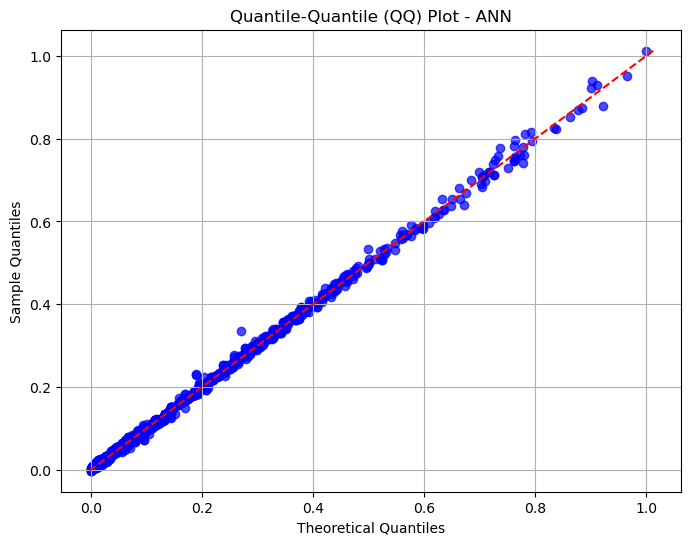

In [218]:

# Plot the QQ plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train_scaled, y_pred_train, c='b', alpha=0.7)
plt.plot([min(y_pred_train), max(y_pred_train)], [min(y_pred_train), max(y_pred_train)], color='red', linestyle='--')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Quantile-Quantile (QQ) Plot - ANN')
plt.grid(True)
plt.show()


In [188]:
# Obtain the number of hidden layers and neurons in each layer
hidden_layers = len(best_model.hidden_layer_sizes)
neurons_per_layer = best_model.hidden_layer_sizes

# Obtain the regularization parameter
alpha = best_model.alpha

print("Number of hidden layers:", hidden_layers)
print("Neurons per layer:", neurons_per_layer)
print("Regularization parameter (alpha):", alpha)

Number of hidden layers: 1
Neurons per layer: (126,)
Regularization parameter (alpha): 0.0001


In [230]:
X = df.iloc[:, 2:-2]
y = df.iloc[:, -1].to_numpy().reshape(-1,1)
y = y + np.random.normal(0, 0.1*np.std(y), y.shape)

#splitting the dataset into training, testing, and validation groups
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size= 0.2,
                                                    random_state = 123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size= 0.2,
                                                    random_state = 123)

# Define MinMaxScaler objects
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Apply scaling to X_train, X_test, and X_val
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled  = X_scaler.transform(X_test)
X_val_scaled   = X_scaler.transform(X_val)

# Apply scaling to y_train, y_test, and y_val
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1))
y_val_scaled   = y_scaler.transform(y_val.reshape(-1, 1))

# Flatten the scaled y arrays
y_train_scaled = y_train_scaled.flatten()
y_test_scaled  = y_test_scaled.flatten()
y_val_scaled   = y_val_scaled.flatten()

start = time()

best_model = MLPRegressor(hidden_layer_sizes=(best_hidden_size,),
                           activation='relu',
                           solver='adam',
                           learning_rate_init=best_learning_rate,
                           random_state=42,
                           early_stopping=True)
print(f'{"Runtime:":<20s} {time()-start:.9f} sec.\n')
# Train the best model
best_model.fit(X_train_scaled, y_train_scaled)

# Make predictions using the best model
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test  = best_model.predict(X_test_scaled)
y_pred_val = best_model.predict(X_val_scaled)

# Calculate metrics for the training set
mse_train = mse(y_train_scaled, y_pred_train)
mae_train = mae(y_train_scaled, y_pred_train)
mape_train= mape(y_train_scaled, y_pred_train)
r2_train = r2(y_train_scaled, y_pred_train)

# Calculate metrics for the testing set
mse_test = mse(y_test_scaled, y_pred_test)
mae_test = mae(y_test_scaled, y_pred_test)
mape_test= mape(y_test_scaled,y_pred_test)
r2_test = r2(y_test_scaled, y_pred_test)

# Calculate metrics for the validation set
mse_val = mse(y_val_scaled, y_pred_val)
mae_val = mae(y_val_scaled, y_pred_val)
mape_val= mape(y_val_scaled,y_pred_val)
r2_val = r2(y_val_scaled, y_pred_val)




# Format metrics and print them
print(f"{'Metric':<12s} {'Training Set':<15s} {'Testing Set':<15s}{'Validation Set':<15s}")
print(f"{'======':<12s} {'============':<15s} {'===========':<15s}{'==============':<15s}\n")
print(f"{'MSE':<15s} {mse_train:<15.4f} {mse_test:<15.4f} {mse_val:<15.4f}")
print(f"{'MAE':<15s} {mae_train:<15.2f} {mae_test:<15.2f} {mae_val:<15.2f}")
print(f"{'MAPE':<15s} {mape_train:<15.2f} {mape_test:<15.2f} {mape_val:<15.2f}")
print(f"{'R2(%)':<15s} {r2_train:<15.2f} {r2_test:<15.2f} {r2_val:<15.2f}")
print(f"\n{'======':<12s} {'============':<15s} {'===========':<15s}{'==============':<15s}\n")

Runtime:             0.000144005 sec.

Metric       Training Set    Testing Set    Validation Set 
======       ============    ===========    ============== 

MSE             0.0003          0.0003          0.0004         
MAE             0.01            0.01            0.02           
MAPE            160932306018.06 0.19            0.18           
R2(%)           0.99            0.99            0.99           

======       ============    ===========    ============== 



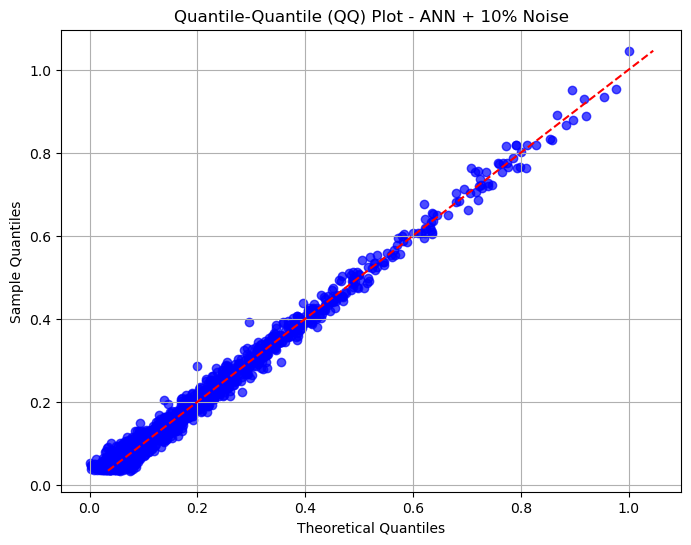

In [231]:

# Plot the QQ plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train_scaled, y_pred_train, c='b', alpha=0.7)
plt.plot([min(y_pred_train), max(y_pred_train)], [min(y_pred_train), max(y_pred_train)], color='red', linestyle='--')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Quantile-Quantile (QQ) Plot - ANN + 10% Noise')
plt.grid(True)
plt.show()


In [234]:
X = df.iloc[:, 2:-2]
y = df.iloc[:, -1].to_numpy().reshape(-1,1)
y = y + np.random.normal(0, 0.2*np.std(y), y.shape)

#splitting the dataset into training, testing, and validation groups
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size= 0.2,
                                                    random_state = 123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size= 0.2,
                                                    random_state = 123)

# Define MinMaxScaler objects
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Apply scaling to X_train, X_test, and X_val
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled  = X_scaler.transform(X_test)
X_val_scaled   = X_scaler.transform(X_val)

# Apply scaling to y_train, y_test, and y_val
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1))
y_val_scaled   = y_scaler.transform(y_val.reshape(-1, 1))

# Flatten the scaled y arrays
y_train_scaled = y_train_scaled.flatten()
y_test_scaled  = y_test_scaled.flatten()
y_val_scaled   = y_val_scaled.flatten()

start = time()

best_model = MLPRegressor(hidden_layer_sizes=(best_hidden_size,),
                           activation='relu',
                           solver='adam',
                           learning_rate_init=best_learning_rate,
                           random_state=42,
                         early_stopping=True)
print(f'{"Runtime:":<20s} {time()-start:.9f} sec.\n')
# Train the best model
best_model.fit(X_train_scaled, y_train_scaled)

# Make predictions using the best model
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test  = best_model.predict(X_test_scaled)
y_pred_val = best_model.predict(X_val_scaled)

# Make predictions using the best model
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test  = best_model.predict(X_test_scaled)
y_pred_val = best_model.predict(X_val_scaled)

# Calculate metrics for the training set
mse_train = mse(y_train_scaled, y_pred_train)
mae_train = mae(y_train_scaled, y_pred_train)
mape_train= mape(y_train_scaled, y_pred_train)
r2_train = r2(y_train_scaled, y_pred_train)

# Calculate metrics for the testing set
mse_test = mse(y_test_scaled, y_pred_test)
mae_test = mae(y_test_scaled, y_pred_test)
mape_test= mape(y_test_scaled,y_pred_test)
r2_test = r2(y_test_scaled, y_pred_test)

# Calculate metrics for the validation set
mse_val = mse(y_val_scaled, y_pred_val)
mae_val = mae(y_val_scaled, y_pred_val)
mape_val= mape(y_val_scaled,y_pred_val)
r2_val = r2(y_val_scaled, y_pred_val)




# Format metrics and print them
print(f"{'Metric':<12s} {'Training Set':<15s} {'Testing Set':<15s}{'Validation Set':<15s}")
print(f"{'======':<12s} {'============':<15s} {'===========':<15s}{'==============':<15s}\n")
print(f"{'MSE':<15s} {mse_train:<15.4f} {mse_test:<15.4f} {mse_val:<15.4f}")
print(f"{'MAE':<15s} {mae_train:<15.2f} {mae_test:<15.2f} {mae_val:<15.2f}")
print(f"{'MAPE':<15s} {mape_train:<15.2f} {mape_test:<15.2f} {mape_val:<15.2f}")
print(f"{'R2(%)':<15s} {r2_train:<15.2f} {r2_test:<15.2f} {r2_val:<15.2f}")
print(f"\n{'======':<12s} {'============':<15s} {'===========':<15s}{'==============':<15s}\n")

Runtime:             0.001883268 sec.

Metric       Training Set    Testing Set    Validation Set 
======       ============    ===========    ============== 

MSE             0.0011          0.0011          0.0011         
MAE             0.03            0.03            0.03           
MAPE            237917686453.30 0.20            0.18           
R2(%)           0.96            0.95            0.95           

======       ============    ===========    ============== 



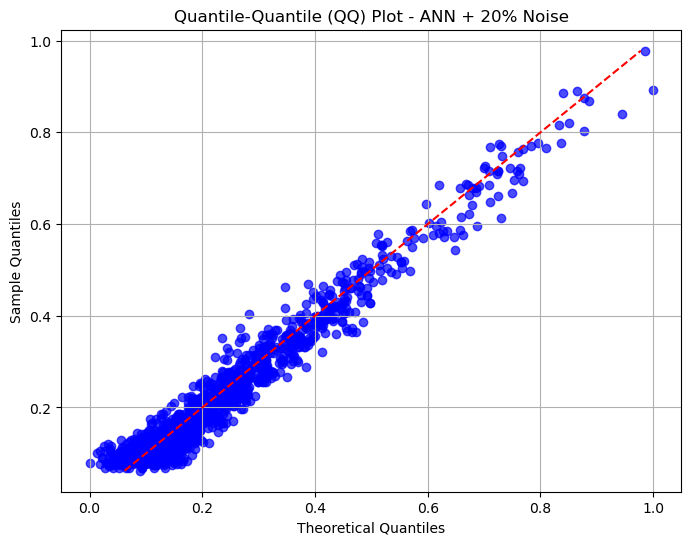

In [235]:

# Plot the QQ plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train_scaled, y_pred_train, c='b', alpha=0.7)
plt.plot([min(y_pred_train), max(y_pred_train)], [min(y_pred_train), max(y_pred_train)], color='red', linestyle='--')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Quantile-Quantile (QQ) Plot - ANN + 20% Noise')
plt.grid(True)
plt.show()
